# Extract and edit results from glacier-snow-cover-mapping to use for melt estimates

### Requirements:
### - csv containing lon/lat coordinates from terminus to headwall
### - folder containing outputs (.nc) from glacier-snow-cover-mapping

## import libraries

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import rasterio

## modify inputs

In [3]:
#inputs - WOLVERINE

#path to csv with lat/lon points along centerline
#format should be lon/lat in order from terminus to headwall
points_path = '/Users/lindsaysummers/Documents/Research/Velocity/Wolverine/RGI_data/'
points_filename = 'centerline_points_latlon_0.5km_spacing.csv'

#path to folder containing results from glacier-snow-cover-mapping
classified_path = '/Users/lindsaysummers/Documents/Research/Snow_Cover/outputs/classified/Wolverine/'

#path to store results
out_path = '/Users/lindsaysummers/Documents/Research/Snow_Cover/outputs/extracted/Wolverine/'

In [2]:
#inputs - Gulkana

#path to csv with lat/lon points along centerline
#format should be lon/lat in order from terminus to headwall
points_path = '/Users/lindsaysummers/Documents/Research/Velocity/Gulkana/RGI_data/'
points_filename = 'centerline_points_latlon_0.5km_spacing.csv'

#path to folder containing results from glacier-snow-cover-mapping (.nc files)
classified_path = '/Users/lindsaysummers/Documents/Research/Snow_Cover/outputs/classified/Gulkana/'

#path to store results
out_path = '/Users/lindsaysummers/Documents/Research/Snow_Cover/outputs/extracted/Gulkana/'

## extract classified results from glacier-snow-cover-mapping results at each centerline point

In [3]:
#import csv containing lat lon points
points_list = pd.read_csv(os.path.join(points_path, points_filename))
points_list = points_list.values.tolist()

#dictionary to store classifications per file
#dictionary keys are time steps (columns), and values are lists of classifications (rows for each point)
#index represents points
classified_data = {}

for file in os.listdir(classified_path):
  if file.endswith('.nc'):
    file_path = os.path.join(classified_path, file)
    print(f"Processing file: {file}")

    #extract date/time from filename for column naming
    try:
        #YYYYMMDDTHHMMSS_
        date_str = file.split('_')[0]
        time_key = datetime.strptime(date_str, '%Y%m%dT%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
    except (IndexError, ValueError):
        #use filename if date extraction fails
        time_key = file
        print(f"Could not parse date from filename {file}. Using filename as column name.")

    classified_values = []
    try:
        with rasterio.open(file_path) as src:
            for pt in points_list:
                #convert longitude, latitude to row, col
                #(longitude, latitude) or (x, y) which is (col, row)
                try:
                    col, row = src.index(pt[0], pt[1])
                    #read single pixel value as a numpy array
                    value_array = src.read(1, window=((col, col+1), (row, row+1)))
                    #extract numerical value from the array
                    numerical_value = value_array[0, 0]

                    #convert numerical value to a string description
                    if numerical_value == 0:
                      value = 'snow'
                    elif numerical_value == 1:
                      value = 'snow'
                    elif numerical_value == 2:
                      value = 'ice'
                    elif numerical_value == 3:
                      value = 'ice'
                    elif numerical_value == 4:
                      value = 'NODATA'
                    else:
                      value = 'NODATA'
                    classified_values.append(value)
                    # print(f"  Point {pt}: {value}")

                except Exception as e:
                     print(f"  Error processing point {pt} in file {file}: {e}")
                     classified_values.append('ERROR')

            #store list of classified values for this file
            classified_data[time_key] = classified_values

    except rasterio.errors.RasterioIOError as e:
        print(f"Error opening or reading raster file {file}: {e}")
        #optionally store list of error indicators for this file
        classified_data[time_key] = ['FILE_ERROR'] * len(points_list)
    except Exception as e:
        print(f"An unexpected error occurred while processing file {file}: {e}")
        classified_data[time_key] = ['UNKNOWN_ERROR'] * len(points_list)

#create a df with classification at each point over time
df = pd.DataFrame(classified_data)

#set index of the DataFrame to be the points
df.index = [str(pt) for pt in points_list] #convert points to strings for indexing

Processing file: 20210416T211734_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20241027T211740_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20150921T210713_Gulkana_Landsat_classified.nc
Processing file: 20221019T210137_Gulkana_Landsat_classified.nc
Processing file: 20200610T211741_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20230605T211743_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20210416T205433_Gulkana_Landsat_classified.nc
Processing file: 20240428T212739_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20240518T212738_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20240602T212738_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20180204T212652_Gulkana_Sentinel-2_TOA_classified.nc
Processing file: 20220524T212737_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20220302T211736_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20220519T212743_Gulkana_Sentinel-2_SR_classified.nc
Processing file: 20220429T212742_Gulkana_Sentinel-2

## process each point

In [4]:
#convert lat/lon to string keys
latlon_keys = [str(p) for p in points_list]

In [5]:
#function to re-classify each point to just snow, ice, or nan
def process_point(df, key):
    pt = df.loc[key]
    pt_df = pd.DataFrame(pt)

    #replace unwanted values with nan
    pt_df.replace(['NODATA', 'ERROR', 'FILE_ERROR', 'UNKNOWN_ERROR'], np.nan, inplace=True)

    #replace labels with numbers
    pt_df.replace('snow', 2, inplace=True)
    pt_df.replace('ice', 1, inplace=True)
    
    #sort df, reset index, rename columns, and convert to datetime format
    pt_df = pt_df.sort_index().reset_index().rename(columns={'index':'time'})
    pt_df['time'] = pd.to_datetime(pt_df['time'])

    return pt_df

In [6]:
#apply function to all points
classified_points = [process_point(df, key) for key in latlon_keys]

/var/folders/64/1n3ltxy16m51f0qpsyhmt0t0rh6mfg/T/ipykernel_43743/1553286892.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pt_df.replace('ice', 1, inplace=True)
/var/folders/64/1n3ltxy16m51f0qpsyhmt0t0rh6mfg/T/ipykernel_43743/1553286892.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pt_df.replace('ice', 1, inplace=True)
/var/folders/64/1n3ltxy16m51f0qpsyhmt0t0rh6mfg/T/ipykernel_43743/1553286892.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

## plot classification results

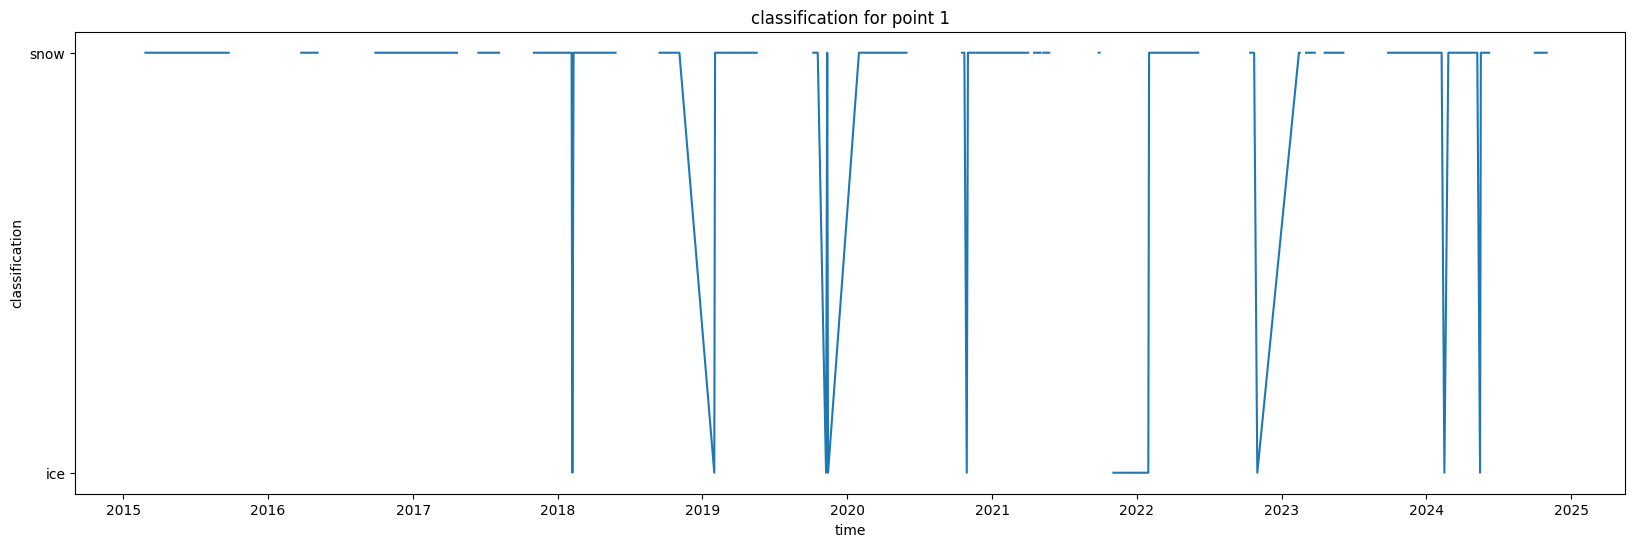

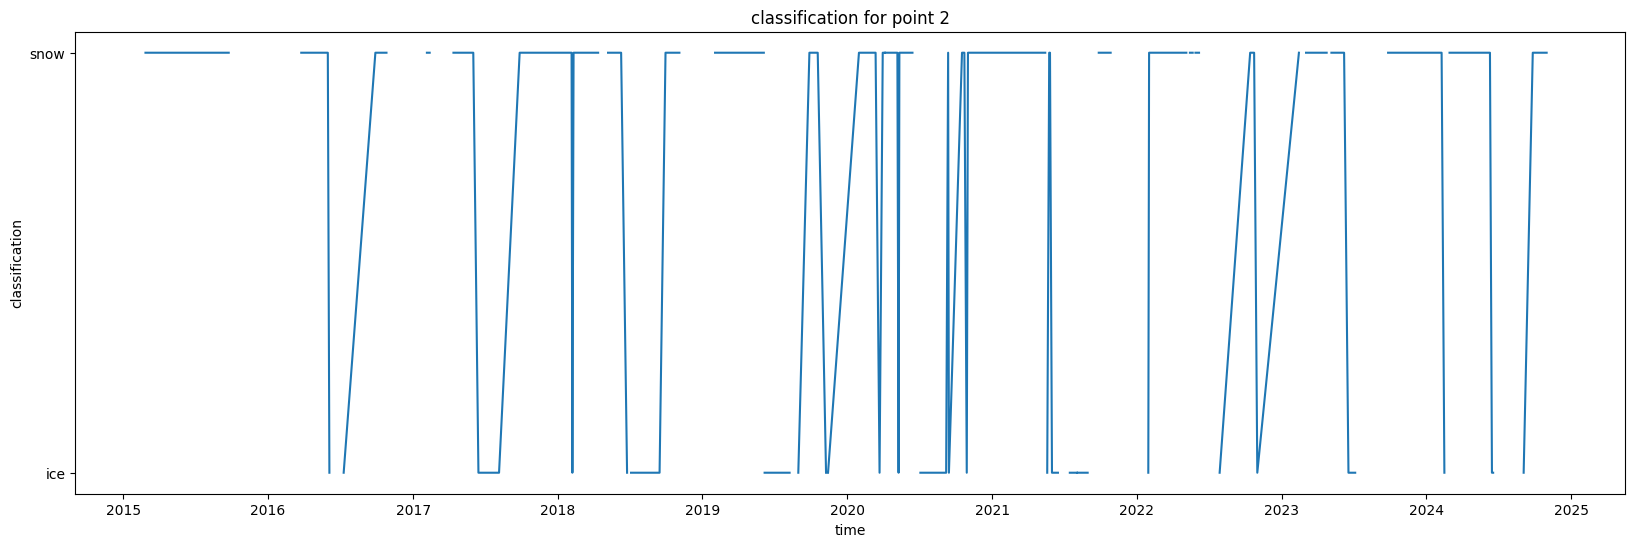

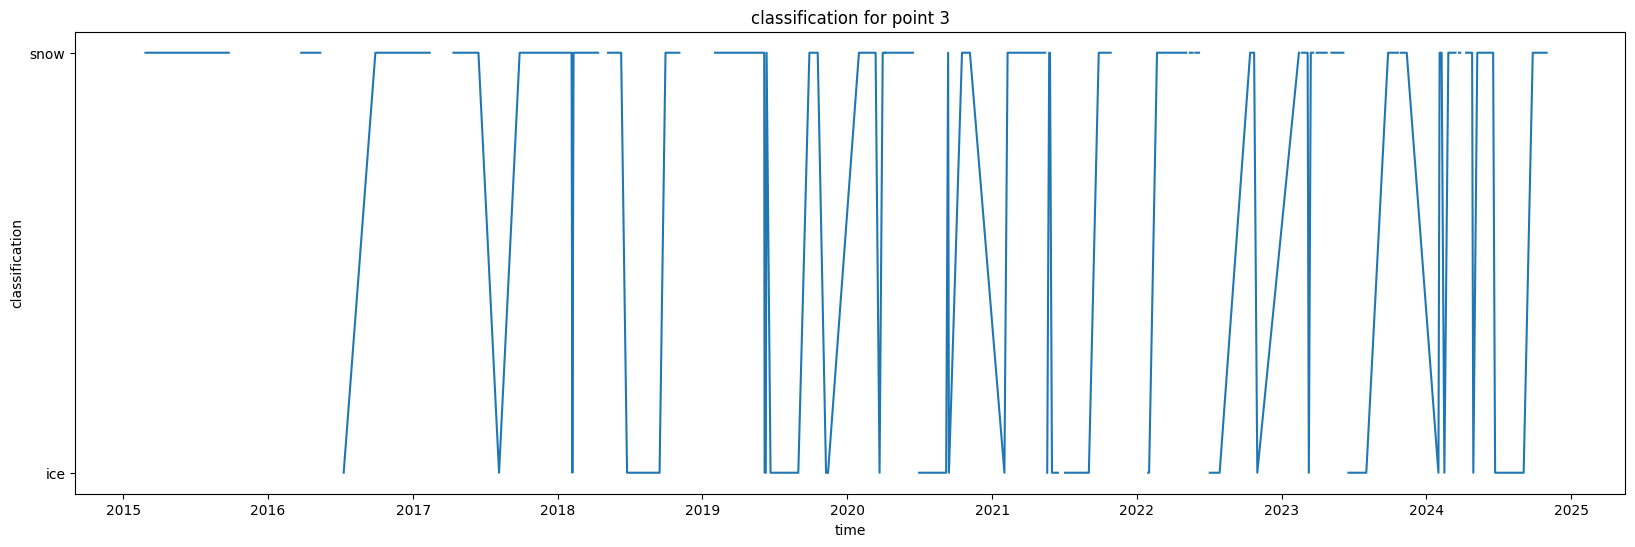

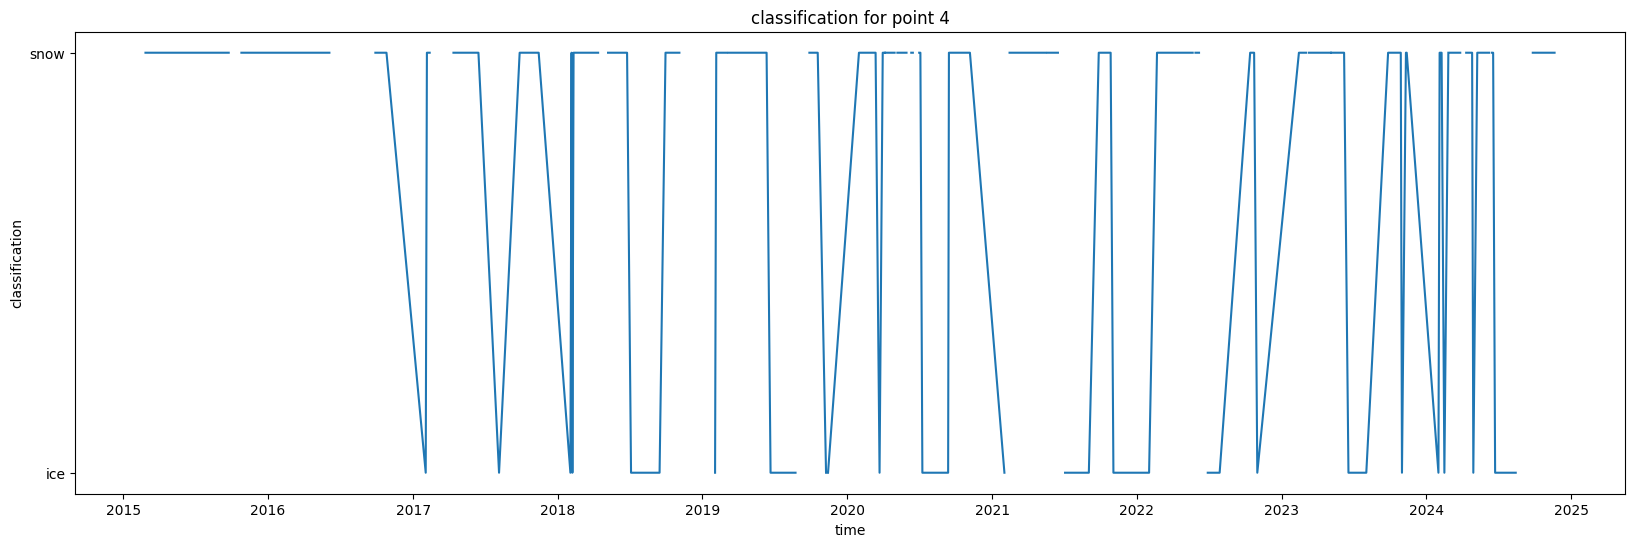

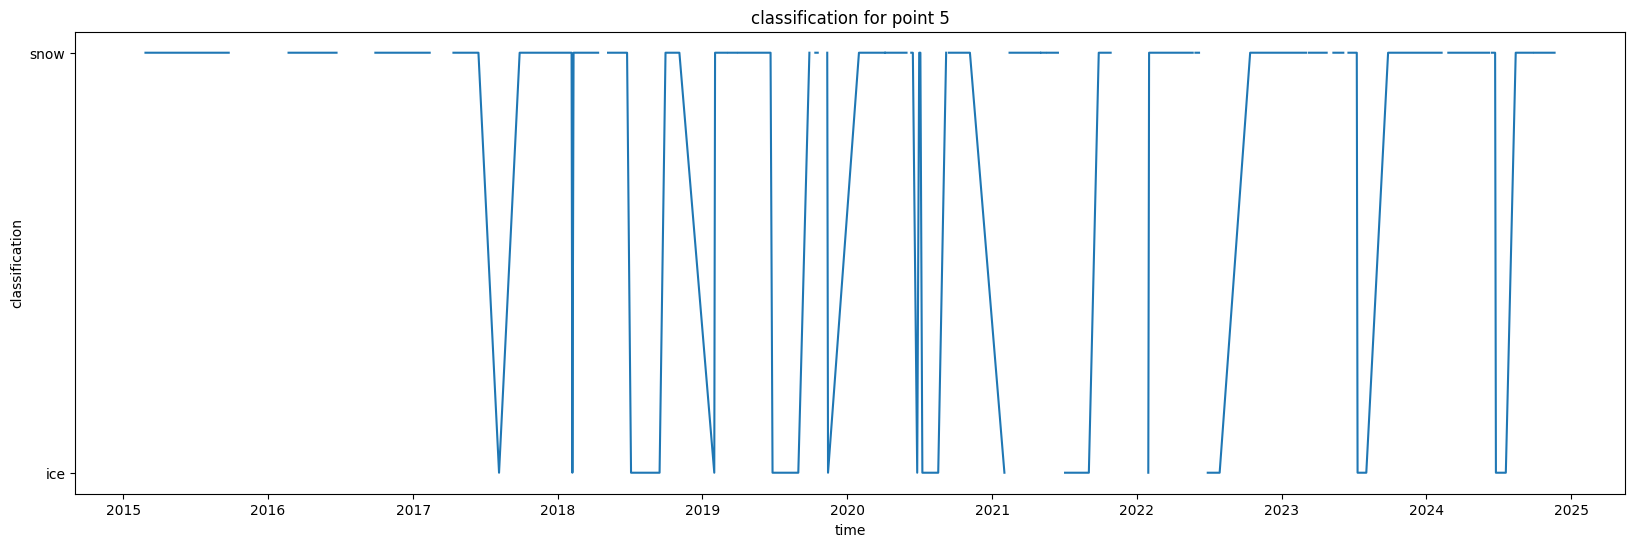

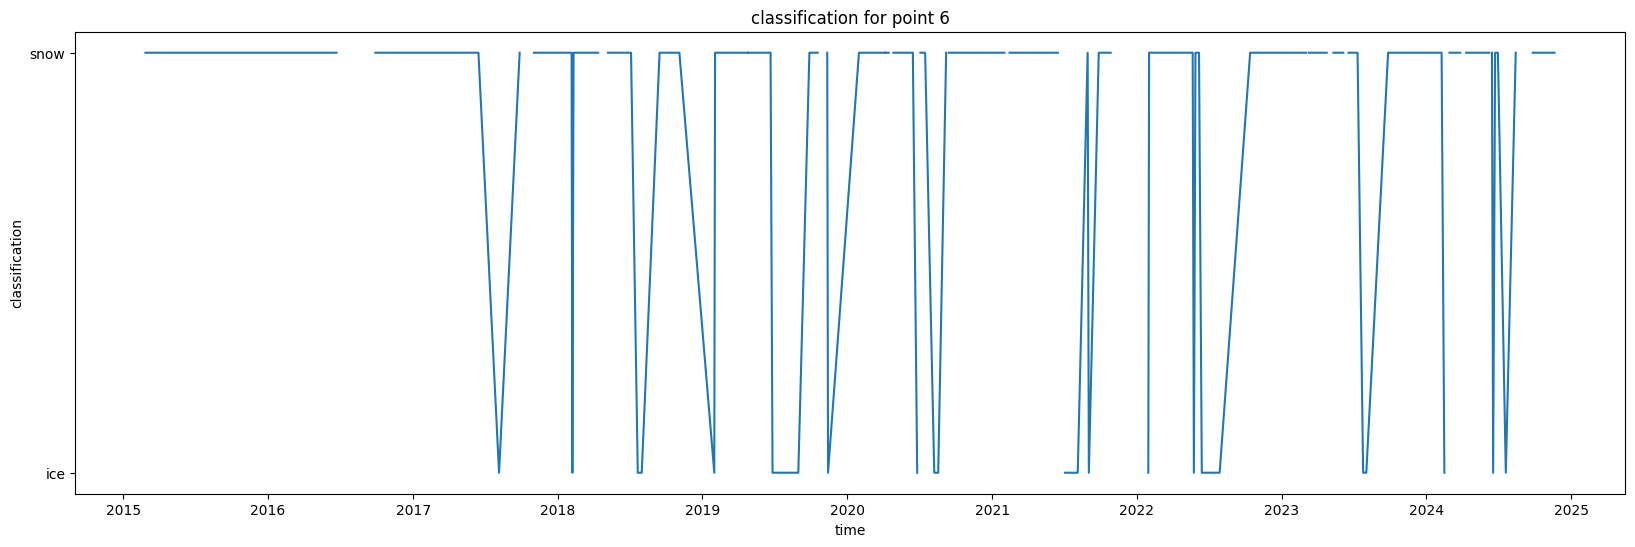

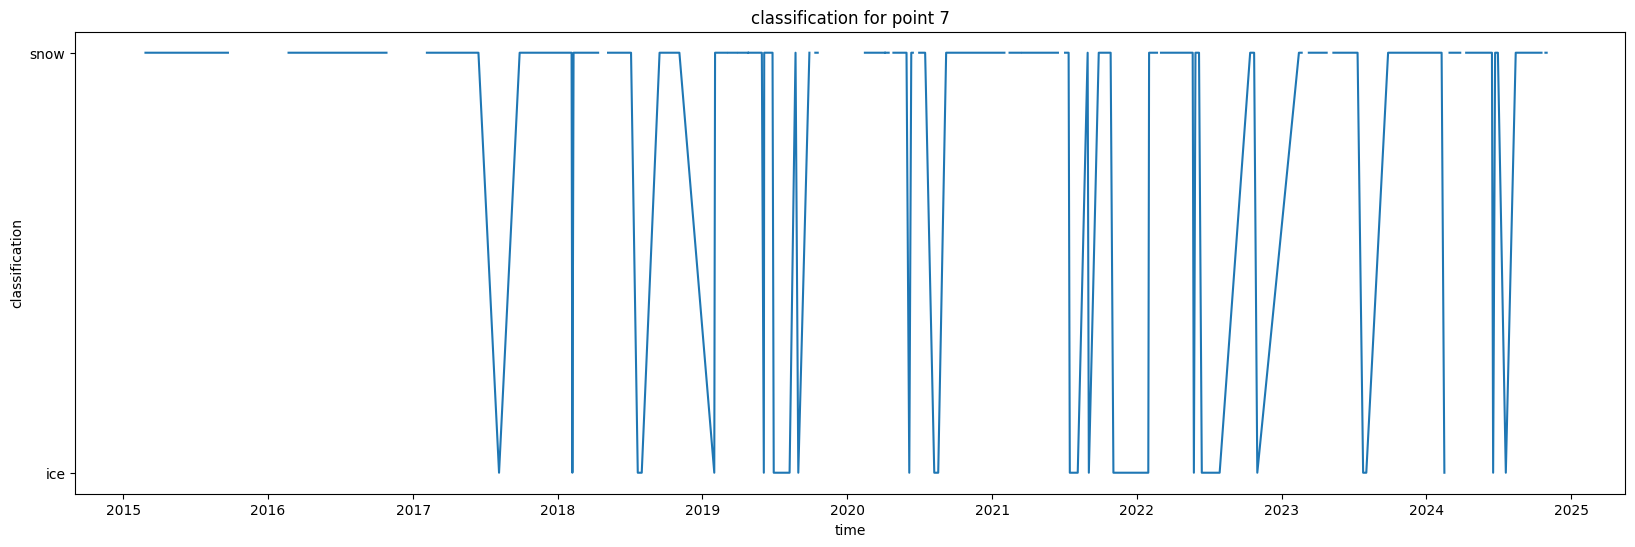

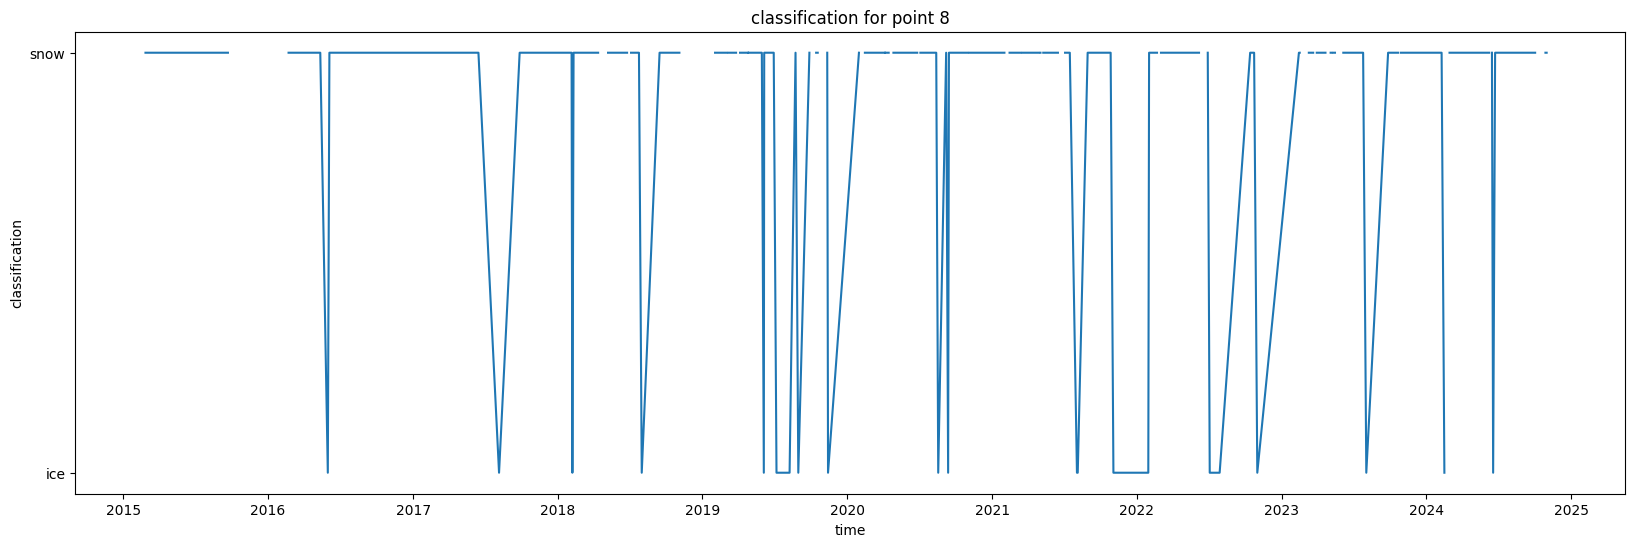

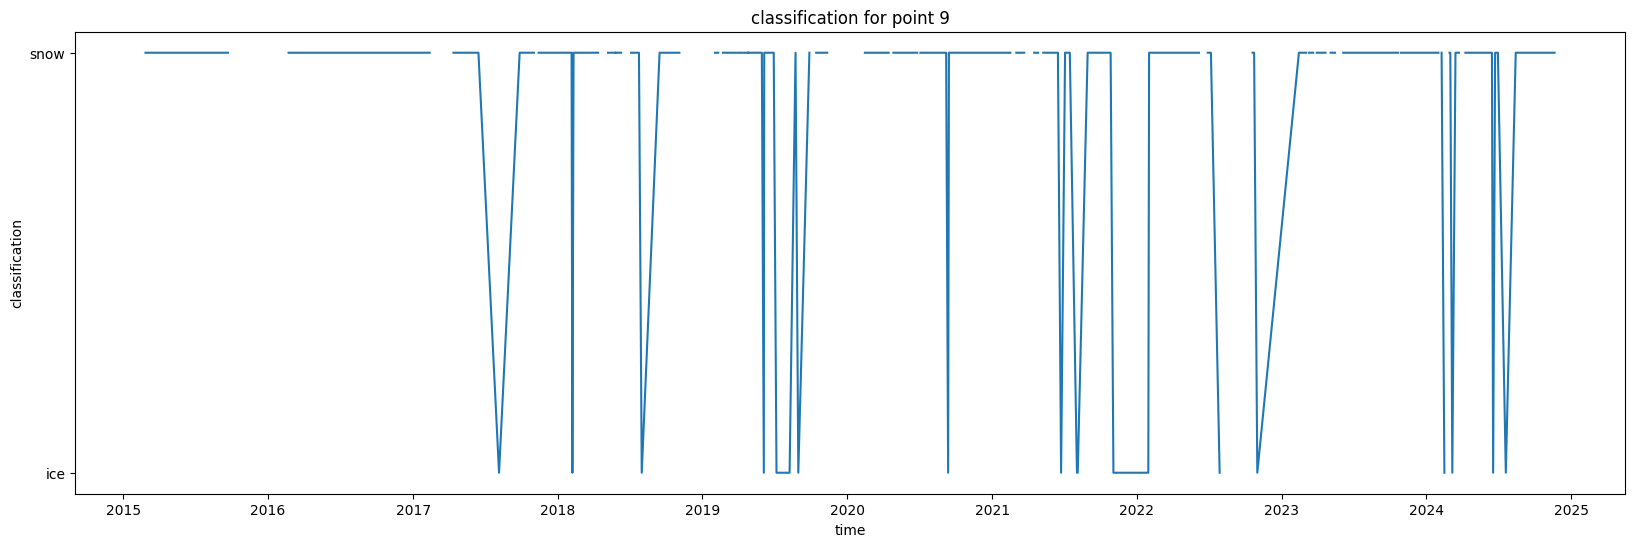

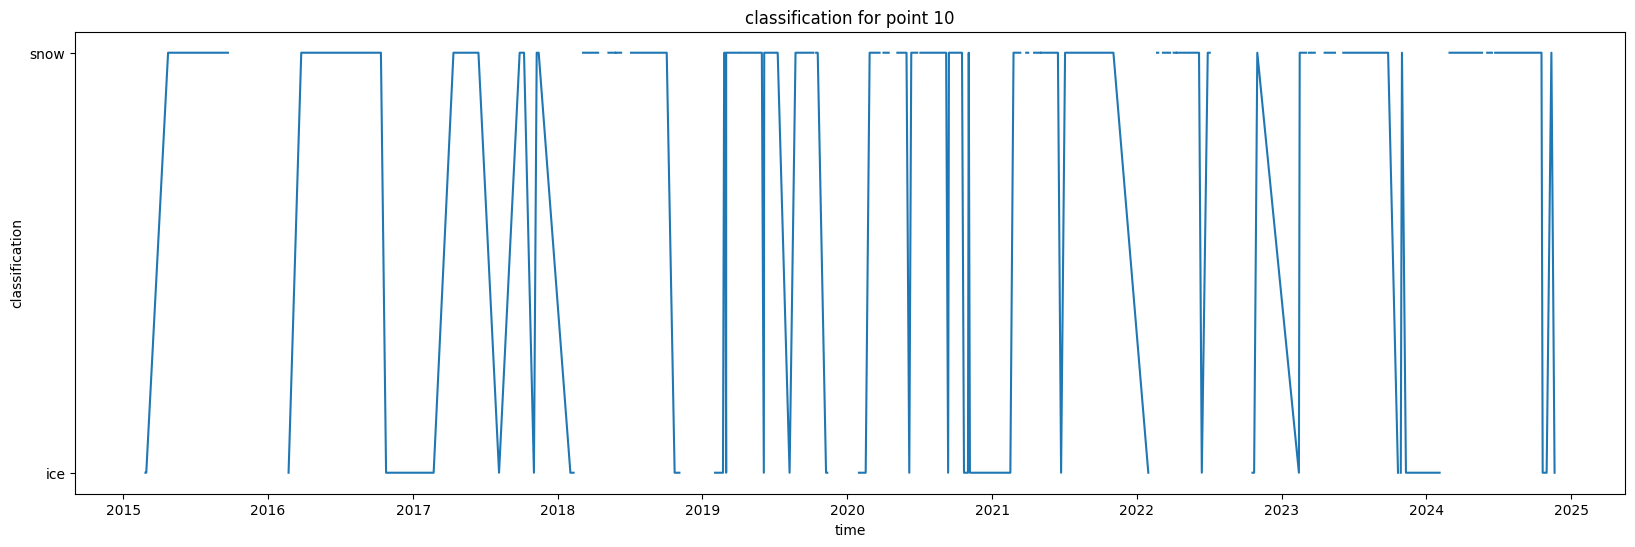

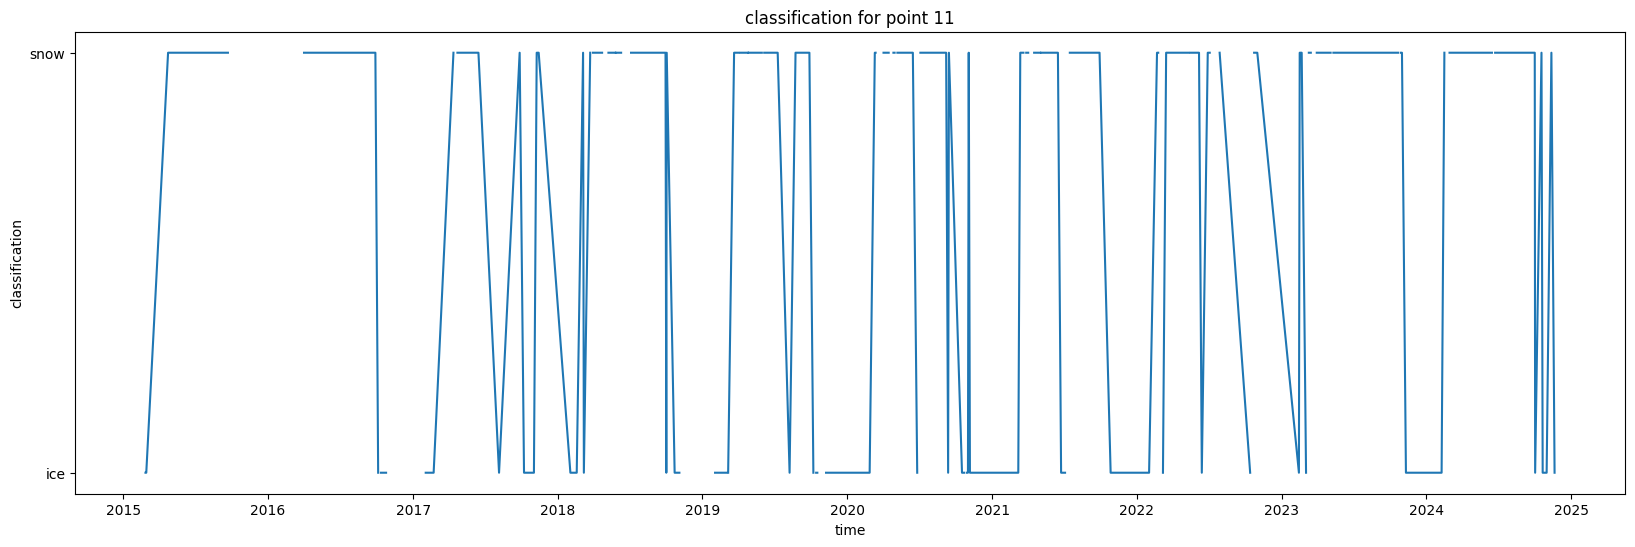

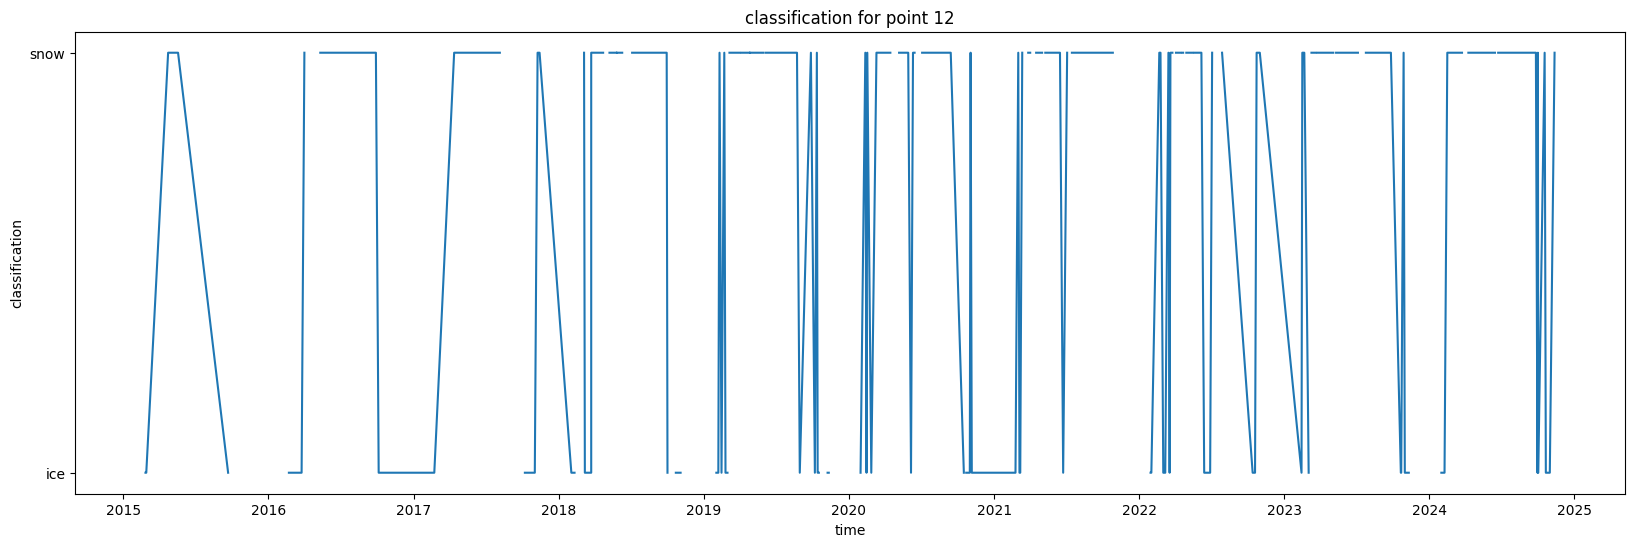

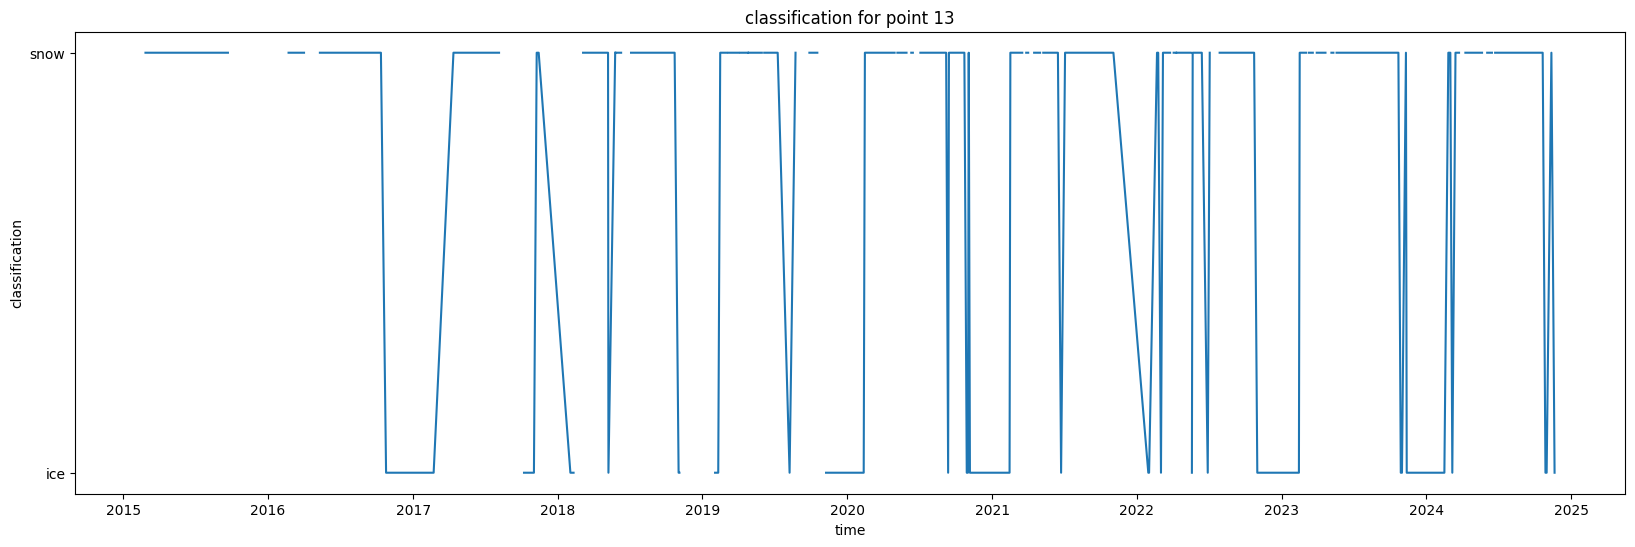

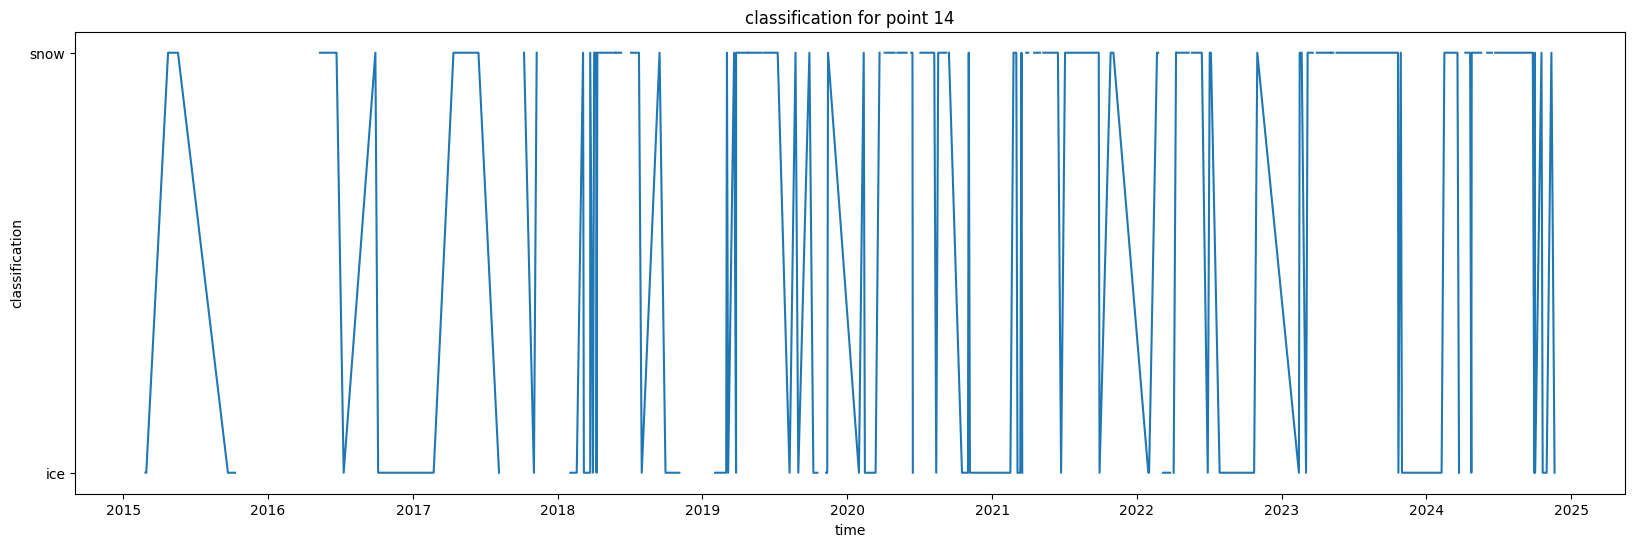

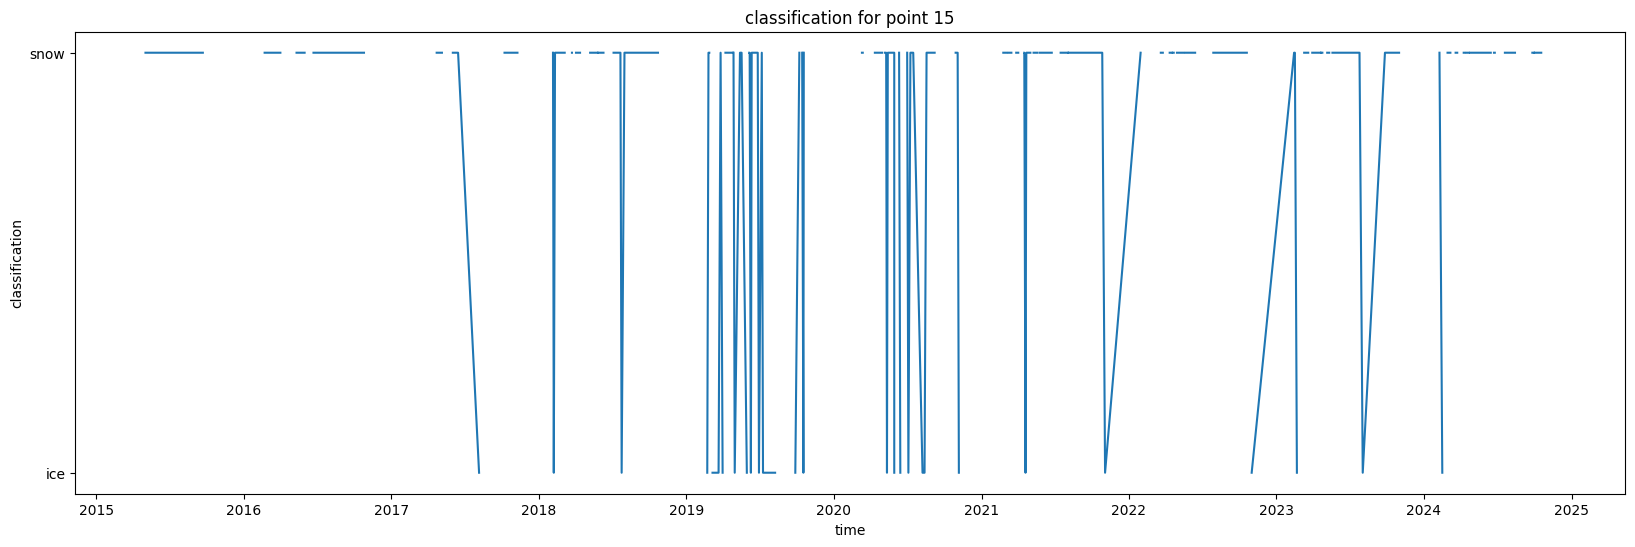

In [7]:
#plot classification results for each point
for i, pt_df in enumerate(classified_points):
    plt.figure(figsize=(20,6))
    plt.plot(pt_df['time'], pt_df.iloc[:,1])
    plt.title(f'classification for point {i+1}')
    plt.xlabel('time')
    plt.ylabel('classification')
    plt.yticks([1,2], ['ice', 'snow'])
    plt.tight_layout
    plt.show()

In [8]:
#export extracted classification
#for pt_name, df in classified_points.items():
#    df.to_csv(f'{out_path}{pt_name}_classified.csv', index=False)

## manually edit "ice-on" days (optional)

### Gulkana:

In [9]:
#2017
pt1_ice_cover_2017 = pd.date_range(start='2017-06-14', end='2017-10-07', freq='D')
pt1_ice_cover_2017 = pd.DataFrame({'time': pt1_ice_cover_2017})
pt4_ice_cover_2017 = pd.date_range(start='2017-06-14', end='2017-10-07', freq='D')
pt4_ice_cover_2017 = pd.DataFrame({'time': pt4_ice_cover_2017})
pt3_ice_cover_2017 = pd.date_range(start='2017-06-14', end='2017-10-07', freq='D')
pt3_ice_cover_2017 = pd.DataFrame({'time': pt3_ice_cover_2017})
pt2_ice_cover_2017 = pd.date_range(start='2017-06-14', end='2017-10-07', freq='D')
pt2_ice_cover_2017 = pd.DataFrame({'time': pt2_ice_cover_2017})
pt6_ice_cover_2017 = pd.date_range(start='2017-06-14', end='2017-10-07', freq='D')
pt6_ice_cover_2017 = pd.DataFrame({'time': pt6_ice_cover_2017})
pt5_ice_cover_2017 = pd.date_range(start='2017-06-14', end='2017-10-07', freq='D')
pt5_ice_cover_2017 = pd.DataFrame({'time': pt5_ice_cover_2017})
pt8_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-07', freq='D')
pt8_ice_cover_2017 = pd.DataFrame({'time': pt8_ice_cover_2017})
pt7_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-07', freq='D')
pt7_ice_cover_2017 = pd.DataFrame({'time': pt7_ice_cover_2017})
pt10_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-07', freq='D')
pt10_ice_cover_2017 = pd.DataFrame({'time': pt10_ice_cover_2017})
pt9_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-07', freq='D')
pt9_ice_cover_2017 = pd.DataFrame({'time': pt9_ice_cover_2017})

#2018
pt1_ice_cover_2018 = pd.date_range(start='2018-06-24', end='2018-09-14', freq='D')
pt1_ice_cover_2018 = pd.DataFrame({'time': pt1_ice_cover_2018})
pt4_ice_cover_2018 = pd.date_range(start='2018-07-04', end='2018-09-14', freq='D')
pt4_ice_cover_2018 = pd.DataFrame({'time': pt4_ice_cover_2018})
pt3_ice_cover_2018 = pd.date_range(start='2018-07-04', end='2018-09-14', freq='D')
pt3_ice_cover_2018 = pd.DataFrame({'time': pt3_ice_cover_2018})
pt2_ice_cover_2018 = pd.date_range(start='2018-07-04', end='2018-09-14', freq='D')
pt2_ice_cover_2018 = pd.DataFrame({'time': pt2_ice_cover_2018})
pt6_ice_cover_2018 = pd.date_range(start='2018-07-04', end='2018-09-14', freq='D')
pt6_ice_cover_2018 = pd.DataFrame({'time': pt6_ice_cover_2018})
pt5_ice_cover_2018 = pd.date_range(start='2018-07-04', end='2018-09-14', freq='D')
pt5_ice_cover_2018 = pd.DataFrame({'time': pt5_ice_cover_2018})
pt8_ice_cover_2018 = pd.date_range(start='2018-07-24', end='2018-09-14', freq='D')
pt8_ice_cover_2018 = pd.DataFrame({'time': pt8_ice_cover_2018})
pt7_ice_cover_2018 = pd.date_range(start='2018-07-24', end='2018-09-14', freq='D')
pt7_ice_cover_2018 = pd.DataFrame({'time': pt7_ice_cover_2018})
pt10_ice_cover_2018 = pd.date_range(start='2018-09-14', end='2018-09-14', freq='D')
pt10_ice_cover_2018 = pd.DataFrame({'time': pt10_ice_cover_2018})
pt9_ice_cover_2018 = pd.date_range(start='2018-09-14', end='2018-09-14', freq='D')
pt9_ice_cover_2018 = pd.DataFrame({'time': pt9_ice_cover_2018})

#2019
pt1_ice_cover_2019 = pd.date_range(start='2019-06-21', end='2019-09-27', freq='D')
pt1_ice_cover_2019 = pd.DataFrame({'time': pt1_ice_cover_2019})
pt4_ice_cover_2019 = pd.date_range(start='2019-06-21', end='2019-09-27', freq='D')
pt4_ice_cover_2019 = pd.DataFrame({'time': pt4_ice_cover_2019})
pt3_ice_cover_2019 = pd.date_range(start='2019-06-21', end='2019-09-27', freq='D')
pt3_ice_cover_2019 = pd.DataFrame({'time': pt3_ice_cover_2019})
pt2_ice_cover_2019 = pd.date_range(start='2019-06-21', end='2019-09-27', freq='D')
pt2_ice_cover_2019 = pd.DataFrame({'time': pt2_ice_cover_2019})
pt6_ice_cover_2019 = pd.date_range(start='2019-06-26', end='2019-09-27', freq='D')
pt6_ice_cover_2019 = pd.DataFrame({'time': pt6_ice_cover_2019})
pt5_ice_cover_2019 = pd.date_range(start='2019-06-26', end='2019-09-27', freq='D')
pt5_ice_cover_2019 = pd.DataFrame({'time': pt5_ice_cover_2019})
pt8_ice_cover_2019 = pd.date_range(start='2019-06-29', end='2019-08-23', freq='D')
pt8_ice_cover_2019 = pd.DataFrame({'time': pt8_ice_cover_2019})
pt7_ice_cover_2019 = pd.date_range(start='2019-06-29', end='2019-08-23', freq='D')
pt7_ice_cover_2019 = pd.DataFrame({'time': pt7_ice_cover_2019})
pt10_ice_cover_2019 = pd.date_range(start='2019-07-09', end='2019-08-23', freq='D')
pt10_ice_cover_2019 = pd.DataFrame({'time': pt10_ice_cover_2019})
pt9_ice_cover_2019 = pd.date_range(start='2019-07-09', end='2019-08-23', freq='D')
pt9_ice_cover_2019 = pd.DataFrame({'time': pt9_ice_cover_2019})

#2020
pt1_ice_cover_2020 = pd.date_range(start='2020-07-08', end='2020-10-16', freq='D')
pt1_ice_cover_2020 = pd.DataFrame({'time': pt1_ice_cover_2020})
pt4_ice_cover_2020 = pd.date_range(start='2020-07-08', end='2020-10-16', freq='D')
pt4_ice_cover_2020 = pd.DataFrame({'time': pt4_ice_cover_2020})
pt3_ice_cover_2020 = pd.date_range(start='2020-07-08', end='2020-10-16', freq='D')
pt3_ice_cover_2020 = pd.DataFrame({'time': pt3_ice_cover_2020})
pt2_ice_cover_2020 = pd.date_range(start='2020-07-08', end='2020-10-16', freq='D')
pt2_ice_cover_2020 = pd.DataFrame({'time': pt2_ice_cover_2020})
pt6_ice_cover_2020 = pd.date_range(start='2020-07-15', end='2020-09-06', freq='D')
pt6_ice_cover_2020 = pd.DataFrame({'time': pt6_ice_cover_2020})
pt5_ice_cover_2020 = pd.date_range(start='2020-07-15', end='2020-09-06', freq='D')
pt5_ice_cover_2020 = pd.DataFrame({'time': pt5_ice_cover_2020})
pt8_ice_cover_2020 = pd.date_range(start='2020-08-07', end='2020-09-06', freq='D')
pt8_ice_cover_2020 = pd.DataFrame({'time': pt8_ice_cover_2020})
pt7_ice_cover_2020 = pd.date_range(start='2020-08-07', end='2020-09-06', freq='D')
pt7_ice_cover_2020 = pd.DataFrame({'time': pt7_ice_cover_2020})

#2021
pt1_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt1_ice_cover_2021 = pd.DataFrame({'time': pt1_ice_cover_2021})
pt4_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt4_ice_cover_2021 = pd.DataFrame({'time': pt4_ice_cover_2021})
pt3_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt3_ice_cover_2021 = pd.DataFrame({'time': pt3_ice_cover_2021})
pt2_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt2_ice_cover_2021 = pd.DataFrame({'time': pt2_ice_cover_2021})
pt6_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt6_ice_cover_2021 = pd.DataFrame({'time': pt6_ice_cover_2021})
pt5_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt5_ice_cover_2021 = pd.DataFrame({'time': pt5_ice_cover_2021})
pt8_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-08-29', freq='D')
pt8_ice_cover_2021 = pd.DataFrame({'time': pt8_ice_cover_2021})
pt7_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-08-29', freq='D')
pt7_ice_cover_2021 = pd.DataFrame({'time': pt7_ice_cover_2021})
pt10_ice_cover_2021 = pd.date_range(start='2021-08-02', end='2021-08-29', freq='D')
pt10_ice_cover_2021 = pd.DataFrame({'time': pt10_ice_cover_2021})
pt9_ice_cover_2021 = pd.date_range(start='2021-08-02', end='2021-08-29', freq='D')
pt9_ice_cover_2021 = pd.DataFrame({'time': pt9_ice_cover_2021})

#2022
pt1_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt1_ice_cover_2022 = pd.DataFrame({'time': pt1_ice_cover_2022})
pt4_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt4_ice_cover_2022 = pd.DataFrame({'time': pt4_ice_cover_2022})
pt3_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt3_ice_cover_2022 = pd.DataFrame({'time': pt3_ice_cover_2022})
pt2_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt2_ice_cover_2022 = pd.DataFrame({'time': pt2_ice_cover_2022})
pt6_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt6_ice_cover_2022 = pd.DataFrame({'time': pt6_ice_cover_2022})
pt5_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt5_ice_cover_2022 = pd.DataFrame({'time': pt5_ice_cover_2022})
pt8_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt8_ice_cover_2022 = pd.DataFrame({'time': pt8_ice_cover_2022})
pt7_ice_cover_2022 = pd.date_range(start='2022-07-03', end='2022-10-13', freq='D')
pt7_ice_cover_2022 = pd.DataFrame({'time': pt7_ice_cover_2022})
pt10_ice_cover_2022 = pd.date_range(start='2022-07-28', end='2022-10-13', freq='D')
pt10_ice_cover_2022 = pd.DataFrame({'time': pt10_ice_cover_2022})
pt9_ice_cover_2022 = pd.date_range(start='2022-07-28', end='2022-10-13', freq='D')
pt9_ice_cover_2022 = pd.DataFrame({'time': pt9_ice_cover_2022})

#2023
pt1_ice_cover_2023 = pd.date_range(start='2023-07-11', end='2023-09-26', freq='D')
pt1_ice_cover_2023 = pd.DataFrame({'time': pt1_ice_cover_2023})
pt4_ice_cover_2023 = pd.date_range(start='2023-07-11', end='2023-09-26', freq='D')
pt4_ice_cover_2023 = pd.DataFrame({'time': pt4_ice_cover_2023})
pt3_ice_cover_2023 = pd.date_range(start='2023-07-11', end='2023-09-26', freq='D')
pt3_ice_cover_2023 = pd.DataFrame({'time': pt3_ice_cover_2023})
pt2_ice_cover_2023 = pd.date_range(start='2023-07-11', end='2023-09-26', freq='D')
pt2_ice_cover_2023 = pd.DataFrame({'time': pt2_ice_cover_2023})
pt6_ice_cover_2023 = pd.date_range(start='2023-07-25', end='2023-09-26', freq='D')
pt6_ice_cover_2023 = pd.DataFrame({'time': pt6_ice_cover_2023})
pt5_ice_cover_2023 = pd.date_range(start='2023-07-25', end='2023-09-26', freq='D')
pt5_ice_cover_2023 = pd.DataFrame({'time': pt5_ice_cover_2023})
pt8_ice_cover_2023 = pd.date_range(start='2023-07-25', end='2023-09-26', freq='D')
pt8_ice_cover_2023 = pd.DataFrame({'time': pt8_ice_cover_2023})
pt7_ice_cover_2023 = pd.date_range(start='2023-07-25', end='2023-09-26', freq='D')
pt7_ice_cover_2023 = pd.DataFrame({'time': pt7_ice_cover_2023})

#2024
pt1_ice_cover_2024 = pd.date_range(start='2024-06-22', end='2024-09-25', freq='D')
pt1_ice_cover_2024 = pd.DataFrame({'time': pt1_ice_cover_2024})
pt4_ice_cover_2024 = pd.date_range(start='2024-06-22', end='2024-09-25', freq='D')
pt4_ice_cover_2024 = pd.DataFrame({'time': pt4_ice_cover_2024})
pt3_ice_cover_2024 = pd.date_range(start='2024-06-22', end='2024-09-25', freq='D')
pt3_ice_cover_2024 = pd.DataFrame({'time': pt3_ice_cover_2024})
pt2_ice_cover_2024 = pd.date_range(start='2024-06-22', end='2024-09-25', freq='D')
pt2_ice_cover_2024 = pd.DataFrame({'time': pt2_ice_cover_2024})
pt6_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-08-13', freq='D')
pt6_ice_cover_2024 = pd.DataFrame({'time': pt6_ice_cover_2024})
pt5_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-08-13', freq='D')
pt5_ice_cover_2024 = pd.DataFrame({'time': pt5_ice_cover_2024})
pt8_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-08-13', freq='D')
pt8_ice_cover_2024 = pd.DataFrame({'time': pt8_ice_cover_2024})
pt7_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-08-13', freq='D')
pt7_ice_cover_2024 = pd.DataFrame({'time': pt7_ice_cover_2024})

In [10]:
#organize ice-cover date ranges

manual_ice_cover = {
    'pt1': {
        2017: pt1_ice_cover_2017,
        2018: pt1_ice_cover_2018,
        2019: pt1_ice_cover_2019,
        2020: pt1_ice_cover_2020,
        2021: pt1_ice_cover_2021,
        2022: pt1_ice_cover_2022,
        2023: pt1_ice_cover_2023,
        2024: pt1_ice_cover_2024,
    },
    'pt2': {
        2017: pt2_ice_cover_2017,
        2018: pt2_ice_cover_2018,
        2019: pt2_ice_cover_2019,
        2020: pt2_ice_cover_2020,
        2021: pt2_ice_cover_2021,
        2022: pt2_ice_cover_2022,
        2023: pt2_ice_cover_2023,
        2024: pt2_ice_cover_2024,
    },
    'pt3': {
        2017: pt3_ice_cover_2017,
        2018: pt3_ice_cover_2018,
        2019: pt3_ice_cover_2019,
        2020: pt3_ice_cover_2020,
        2021: pt3_ice_cover_2021,
        2022: pt3_ice_cover_2022,
        2023: pt3_ice_cover_2023,
        2024: pt3_ice_cover_2024,
    },
    'pt4': {
        2017: pt4_ice_cover_2017,
        2018: pt4_ice_cover_2018,
        2019: pt4_ice_cover_2019,
        2020: pt4_ice_cover_2020,
        2021: pt4_ice_cover_2021,
        2022: pt4_ice_cover_2022,
        2023: pt4_ice_cover_2023,
        2024: pt4_ice_cover_2024,
    },
    'pt5': {
        2017: pt5_ice_cover_2017,
        2018: pt5_ice_cover_2018,
        2019: pt5_ice_cover_2019,
        2020: pt5_ice_cover_2020,
        2021: pt5_ice_cover_2021,
        2022: pt5_ice_cover_2022,
        2023: pt5_ice_cover_2023,
        2024: pt5_ice_cover_2024,
    },
    'pt6': {
        2017: pt6_ice_cover_2017,
        2018: pt6_ice_cover_2018,
        2019: pt6_ice_cover_2019,
        2020: pt6_ice_cover_2020,
        2021: pt6_ice_cover_2021,
        2022: pt6_ice_cover_2022,
        2023: pt6_ice_cover_2023,
        2024: pt6_ice_cover_2024,
    },
    'pt7': {
        2018: pt7_ice_cover_2018,
        2019: pt7_ice_cover_2019,
        2020: pt7_ice_cover_2020,
        2021: pt7_ice_cover_2021,
        2022: pt7_ice_cover_2022,
        2023: pt7_ice_cover_2023,
        2024: pt7_ice_cover_2024,
    },
    'pt8': {
        2017: pt8_ice_cover_2017,
        2018: pt8_ice_cover_2018,
        2019: pt8_ice_cover_2019,
        2020: pt8_ice_cover_2020,
        2021: pt8_ice_cover_2021,
        2022: pt8_ice_cover_2022,
        2023: pt8_ice_cover_2023,
        2024: pt8_ice_cover_2024,
    },
    'pt9': {
        2018: pt9_ice_cover_2018,
        2019: pt9_ice_cover_2019,
        2021: pt9_ice_cover_2021,
        2022: pt9_ice_cover_2022,
    },
    'pt10': {
        2017: pt10_ice_cover_2017,
        2018: pt10_ice_cover_2018,
        2019: pt10_ice_cover_2019,
        2021: pt10_ice_cover_2021,
        2022: pt10_ice_cover_2022,
    },
    'pt11': {},
    'pt12': {},
    'pt13': {},
    'pt14': {},
    'pt15': {},
}

In [11]:
#function to combine manual ice-on days into a single df
def apply_manual_ice_cover(df, manual_ice_df):
    """
    Given a classification DataFrame `df` with a 'time' column,
    and a DataFrame `manual_ice_df` with 'time' column for manual ice cover dates,
    set the classification to 1 (ice) on those dates.
    """
    #convert to datetime
    df['time'] = pd.to_datetime(df['time'])
    manual_ice_dates = pd.to_datetime(manual_ice_df['time'])

    #set classification to 1 (ice) where time is in manual ice cover dates
    df.loc[df['time'].isin(manual_ice_dates), df.columns[1]] = 1  # assumes classification col is 2nd column

    return df

In [12]:
#make classified_points into a dictioinary
classified_points_dict = {}

for i, df in enumerate(classified_points, start=1):
    key = f'pt{i}'
    classified_points_dict[key] = df

In [13]:
for pt_name, pt_df in classified_points_dict.items():
    if pt_name in manual_ice_cover:
        for year, manual_ice_df in manual_ice_cover[pt_name].items():
            # manual_ice_df should be a DataFrame with 'time' column

            #filter and apply
            year_mask = pt_df['time'].dt.year == year
            pt_df_year = pt_df.loc[year_mask].copy()
            pt_df_year = apply_manual_ice_cover(pt_df_year, manual_ice_df)
            pt_df.loc[year_mask, pt_df.columns[1]] = pt_df_year[pt_df.columns[1]]
#        print(pt_df)

In [14]:
#replace last "ice-on" day with value for snow
# Format: 'pt_name': [(date, classification_column_name)]
manual_last_ice_to_snow = {
    'pt1': [
        ('2017-10-07', '[-145.431, 63.258]'),
        ('2018-09-14', '[-145.431, 63.258]'),
        ('2019-09-27', '[-145.431, 63.258]'),
        ('2020-10-16', '[-145.431, 63.258]'),
        ('2021-09-26', '[-145.431, 63.258]'),
        ('2022-10-13', '[-145.431, 63.258]'),
        ('2023-09-26', '[-145.431, 63.258]'),
        ('2024-09-25', '[-145.431, 63.258]'),
        
    ],
    'pt2': [
        ('2017-10-07', '[-145.424, 63.261]'),
        ('2018-09-14', '[-145.424, 63.261]'),
        ('2019-09-27', '[-145.424, 63.261]'),
        ('2020-10-16', '[-145.424, 63.261]'),
        ('2021-09-26', '[-145.424, 63.261]'),
        ('2022-10-13', '[-145.424, 63.261]'),
        ('2023-09-26', '[-145.424, 63.261]'),
        ('2024-09-25', '[-145.424, 63.261]'),
    ],
    'pt3': [
        ('2017-10-07', '[-145.417, 63.264]'),
        ('2018-09-14', '[-145.417, 63.264]'),
        ('2019-09-27', '[-145.417, 63.264]'),
        ('2020-10-16', '[-145.417, 63.264]'),
        ('2021-09-26', '[-145.417, 63.264]'),
        ('2022-10-13', '[-145.417, 63.264]'),
        ('2023-09-26', '[-145.417, 63.264]'),
        ('2024-09-25', '[-145.417, 63.264]'),  
    ],
    'pt4': [
        ('2017-10-07', '[-145.413, 63.268]'),
        ('2018-09-14', '[-145.413, 63.268]'),
        ('2019-09-27', '[-145.413, 63.268]'),
        ('2020-10-16', '[-145.413, 63.268]'),
        ('2021-09-26', '[-145.413, 63.268]'),
        ('2022-10-13', '[-145.413, 63.268]'),
        ('2023-09-26', '[-145.413, 63.268]'),
        ('2024-09-25', '[-145.413, 63.268]'),
    ],
    'pt5': [
        ('2017-10-07', '[-145.414, 63.273]'),
        ('2018-09-14', '[-145.414, 63.273]'),
        ('2019-09-27', '[-145.414, 63.273]'),
        ('2020-09-06', '[-145.414, 63.273]'),
        ('2021-09-26', '[-145.414, 63.273]'),
        ('2022-10-13', '[-145.414, 63.273]'),
        ('2023-09-26', '[-145.414, 63.273]'),
        ('2024-08-13', '[-145.414, 63.273]'),
    ],
    'pt6': [
        ('2017-10-07', '[-145.414, 63.277]'),
        ('2018-09-14', '[-145.414, 63.277]'),
        ('2019-09-27', '[-145.414, 63.277]'),
        ('2020-09-06', '[-145.414, 63.277]'),
        ('2021-09-26', '[-145.414, 63.277]'),
        ('2022-10-13', '[-145.414, 63.277]'),
        ('2023-09-26', '[-145.414, 63.277]'),
        ('2024-08-13', '[-145.414, 63.277]'),
    ],
    'pt7': [
        ('2017-10-07', '[-145.412, 63.281]'),
        ('2018-09-14', '[-145.412, 63.281]'),
        ('2019-08-23', '[-145.412, 63.281]'),
        ('2020-09-06', '[-145.412, 63.281]'),
        ('2021-08-29', '[-145.412, 63.281]'),
        ('2022-10-13', '[-145.412, 63.281]'),
        ('2023-09-26', '[-145.412, 63.281]'),
        ('2024-08-13', '[-145.412, 63.281]'),
    ],
    'pt8': [
        ('2017-10-07', '[-145.41, 63.286]'),
        ('2018-09-14', '[-145.41, 63.286]'),
        ('2019-08-23', '[-145.41, 63.286]'),
        ('2020-09-06', '[-145.41, 63.286]'),
        ('2021-08-29', '[-145.41, 63.286]'),
        ('2022-10-13', '[-145.41, 63.286]'),
        ('2023-09-26', '[-145.41, 63.286]'),
        ('2024-08-13', '[-145.41, 63.286]'),
    ],
    'pt9': [
        ('2017-10-07', '[-145.402, 63.288]'),
        ('2018-09-14', '[-145.402, 63.288]'),
        ('2019-08-23', '[-145.402, 63.288]'),
        ('2021-08-29', '[-145.402, 63.288]'),
        ('2022-10-13', '[-145.402, 63.288]'),
    ],
    'pt10': [
        ('2017-10-07', '[-145.392, 63.288]'),
        ('2018-09-14', '[-145.392, 63.288]'),
        ('2019-08-23', '[-145.392, 63.288]'),
        ('2021-08-29', '[-145.392, 63.288]'),
        ('2022-10-13', '[-145.392, 63.288]'),
    ],
}

In [15]:
for pt_name, updates in manual_last_ice_to_snow.items():
    df = classified_points_dict[pt_name]

    for date_str, col_name in updates:
        # Strip any whitespace and ensure datetime format matches
        date_clean = pd.to_datetime(date_str.strip())

        # Make sure 'time' is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Apply the change: set value to 2.0 (snow) on the given date
        df.loc[df['time'] == date_clean, col_name] = 2.0

### wolverine:

In [9]:
#2015
pt1_ice_cover_2015 = pd.date_range(start='2015-06-17', end='2015-10-15', freq='D')
pt1_ice_cover_2015 = pd.DataFrame({'time': pt1_ice_cover_2015})
pt2_ice_cover_2015 = pd.date_range(start='2015-06-17', end='2015-10-15', freq='D')
pt2_ice_cover_2015 = pd.DataFrame({'time': pt2_ice_cover_2015})
pt4_ice_cover_2015 = pd.date_range(start='2015-07-03', end='2015-10-15', freq='D')
pt4_ice_cover_2015 = pd.DataFrame({'time': pt4_ice_cover_2015})
pt3_ice_cover_2015 = pd.date_range(start='2015-07-03', end='2015-10-15', freq='D')
pt3_ice_cover_2015 = pd.DataFrame({'time': pt3_ice_cover_2015})
pt6_ice_cover_2015 = pd.date_range(start='2015-08-04', end='2015-10-15', freq='D')
pt6_ice_cover_2015 = pd.DataFrame({'time': pt6_ice_cover_2015})
pt5_ice_cover_2015 = pd.date_range(start='2015-08-04', end='2015-10-15', freq='D')
pt5_ice_cover_2015 = pd.DataFrame({'time': pt5_ice_cover_2015})
pt8_ice_cover_2015 = pd.date_range(start='2015-08-04', end='2015-10-15', freq='D')
pt8_ice_cover_2015 = pd.DataFrame({'time': pt8_ice_cover_2015})
pt7_ice_cover_2015 = pd.date_range(start='2015-08-04', end='2015-10-15', freq='D')
pt7_ice_cover_2015 = pd.DataFrame({'time': pt7_ice_cover_2015})
pt10_ice_cover_2015 = pd.date_range(start='2015-08-20', end='2015-10-15', freq='D')
pt10_ice_cover_2015 = pd.DataFrame({'time': pt10_ice_cover_2015})
pt9_ice_cover_2015 = pd.date_range(start='2015-08-20', end='2015-10-15', freq='D')
pt9_ice_cover_2015 = pd.DataFrame({'time': pt9_ice_cover_2015})

#2016
pt1_ice_cover_2016 = pd.date_range(start='2016-07-16', end='2016-10-24', freq='D')
pt1_ice_cover_2016 = pd.DataFrame({'time': pt1_ice_cover_2016})
pt4_ice_cover_2016 = pd.date_range(start='2016-07-16', end='2016-10-24', freq='D')
pt4_ice_cover_2016 = pd.DataFrame({'time': pt4_ice_cover_2016})
pt3_ice_cover_2016 = pd.date_range(start='2016-07-16', end='2016-10-24', freq='D')
pt3_ice_cover_2016 = pd.DataFrame({'time': pt3_ice_cover_2016})
pt2_ice_cover_2016 = pd.date_range(start='2016-07-16', end='2016-10-24', freq='D')
pt2_ice_cover_2016 = pd.DataFrame({'time': pt2_ice_cover_2016})
pt6_ice_cover_2016 = pd.date_range(start='2016-08-31', end='2016-10-24', freq='D')
pt6_ice_cover_2016 = pd.DataFrame({'time': pt6_ice_cover_2016})
pt5_ice_cover_2016 = pd.date_range(start='2016-08-31', end='2016-10-24', freq='D')
pt5_ice_cover_2016 = pd.DataFrame({'time': pt5_ice_cover_2016})


#2017
pt1_ice_cover_2017 = pd.date_range(start='2017-06-01', end='2017-10-19', freq='D')
pt1_ice_cover_2017 = pd.DataFrame({'time': pt1_ice_cover_2017})
pt4_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt4_ice_cover_2017 = pd.DataFrame({'time': pt4_ice_cover_2017})
pt3_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt3_ice_cover_2017 = pd.DataFrame({'time': pt3_ice_cover_2017})
pt2_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt2_ice_cover_2017 = pd.DataFrame({'time': pt2_ice_cover_2017})
pt6_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt6_ice_cover_2017 = pd.DataFrame({'time': pt6_ice_cover_2017})
pt5_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt5_ice_cover_2017 = pd.DataFrame({'time': pt5_ice_cover_2017})
pt8_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt8_ice_cover_2017 = pd.DataFrame({'time': pt8_ice_cover_2017})
pt7_ice_cover_2017 = pd.date_range(start='2017-08-05', end='2017-10-19', freq='D')
pt7_ice_cover_2017 = pd.DataFrame({'time': pt7_ice_cover_2017})

#2018
pt1_ice_cover_2018 = pd.date_range(start='2018-06-09', end='2018-10-31', freq='D')
pt1_ice_cover_2018 = pd.DataFrame({'time': pt1_ice_cover_2018})
pt4_ice_cover_2018 = pd.date_range(start='2018-07-01', end='2018-10-22', freq='D')
pt4_ice_cover_2018 = pd.DataFrame({'time': pt4_ice_cover_2018})
pt3_ice_cover_2018 = pd.date_range(start='2018-07-01', end='2018-10-22', freq='D')
pt3_ice_cover_2018 = pd.DataFrame({'time': pt3_ice_cover_2018})
pt2_ice_cover_2018 = pd.date_range(start='2018-07-01', end='2018-10-22', freq='D')
pt2_ice_cover_2018 = pd.DataFrame({'time': pt2_ice_cover_2018})
pt6_ice_cover_2018 = pd.date_range(start='2018-07-06', end='2018-10-22', freq='D')
pt6_ice_cover_2018 = pd.DataFrame({'time': pt6_ice_cover_2018})
pt5_ice_cover_2018 = pd.date_range(start='2018-07-06', end='2018-10-22', freq='D')
pt5_ice_cover_2018 = pd.DataFrame({'time': pt5_ice_cover_2018})
pt8_ice_cover_2018 = pd.date_range(start='2018-07-31', end='2018-10-08', freq='D')
pt8_ice_cover_2018 = pd.DataFrame({'time': pt8_ice_cover_2018})
pt7_ice_cover_2018 = pd.date_range(start='2018-07-31', end='2018-10-08', freq='D')
pt7_ice_cover_2018 = pd.DataFrame({'time': pt7_ice_cover_2018})
pt10_ice_cover_2018 = pd.date_range(start='2018-07-31', end='2018-10-08', freq='D')
pt10_ice_cover_2018 = pd.DataFrame({'time': pt10_ice_cover_2018})
pt9_ice_cover_2018 = pd.date_range(start='2018-07-31', end='2018-10-08', freq='D')
pt9_ice_cover_2018 = pd.DataFrame({'time': pt9_ice_cover_2018})

#2019
pt1_ice_cover_2019 = pd.date_range(start='2019-06-06', end='2019-10-12', freq='D')
pt1_ice_cover_2019 = pd.DataFrame({'time': pt1_ice_cover_2019})
pt4_ice_cover_2019 = pd.date_range(start='2019-06-19', end='2019-10-12', freq='D')
pt4_ice_cover_2019 = pd.DataFrame({'time': pt4_ice_cover_2019})
pt3_ice_cover_2019 = pd.date_range(start='2019-06-19', end='2019-10-12', freq='D')
pt3_ice_cover_2019 = pd.DataFrame({'time': pt3_ice_cover_2019})
pt2_ice_cover_2019 = pd.date_range(start='2019-06-19', end='2019-10-12', freq='D')
pt2_ice_cover_2019 = pd.DataFrame({'time': pt2_ice_cover_2019})
pt6_ice_cover_2019 = pd.date_range(start='2019-07-01', end='2019-10-12', freq='D')
pt6_ice_cover_2019 = pd.DataFrame({'time': pt6_ice_cover_2019})
pt5_ice_cover_2019 = pd.date_range(start='2019-07-01', end='2019-10-12', freq='D')
pt5_ice_cover_2019 = pd.DataFrame({'time': pt5_ice_cover_2019})
pt8_ice_cover_2019 = pd.date_range(start='2019-07-09', end='2019-10-12', freq='D')
pt8_ice_cover_2019 = pd.DataFrame({'time': pt8_ice_cover_2019})
pt7_ice_cover_2019 = pd.date_range(start='2019-07-09', end='2019-10-12', freq='D')
pt7_ice_cover_2019 = pd.DataFrame({'time': pt7_ice_cover_2019})
pt10_ice_cover_2019 = pd.date_range(start='2019-09-14', end='2019-10-07', freq='D')
pt10_ice_cover_2019 = pd.DataFrame({'time': pt10_ice_cover_2019})
pt9_ice_cover_2019 = pd.date_range(start='2019-09-14', end='2019-10-07', freq='D')
pt9_ice_cover_2019 = pd.DataFrame({'time': pt9_ice_cover_2019})

#2020
pt1_ice_cover_2020 = pd.date_range(start='2020-04-29', end='2020-10-28', freq='D')
pt1_ice_cover_2020 = pd.DataFrame({'time': pt1_ice_cover_2020})
pt4_ice_cover_2020 = pd.date_range(start='2020-06-10', end='2020-10-16', freq='D')
pt4_ice_cover_2020 = pd.DataFrame({'time': pt4_ice_cover_2020})
pt3_ice_cover_2020 = pd.date_range(start='2020-06-10', end='2020-10-16', freq='D')
pt3_ice_cover_2020 = pd.DataFrame({'time': pt3_ice_cover_2020})
pt2_ice_cover_2020 = pd.date_range(start='2020-06-10', end='2020-10-16', freq='D')
pt2_ice_cover_2020 = pd.DataFrame({'time': pt2_ice_cover_2020})
pt6_ice_cover_2020 = pd.date_range(start='2020-06-30', end='2020-10-16', freq='D')
pt6_ice_cover_2020 = pd.DataFrame({'time': pt6_ice_cover_2020})
pt5_ice_cover_2020 = pd.date_range(start='2020-06-30', end='2020-10-16', freq='D')
pt5_ice_cover_2020 = pd.DataFrame({'time': pt5_ice_cover_2020})
pt8_ice_cover_2020 = pd.date_range(start='2020-07-15', end='2020-10-16', freq='D')
pt8_ice_cover_2020 = pd.DataFrame({'time': pt8_ice_cover_2020})
pt7_ice_cover_2020 = pd.date_range(start='2020-07-15', end='2020-10-16', freq='D')
pt7_ice_cover_2020 = pd.DataFrame({'time': pt7_ice_cover_2020})
pt10_ice_cover_2020 = pd.date_range(start='2020-07-15', end='2020-10-16', freq='D')
pt10_ice_cover_2020 = pd.DataFrame({'time': pt10_ice_cover_2020})
pt9_ice_cover_2020 = pd.date_range(start='2020-07-15', end='2020-10-16', freq='D')
pt9_ice_cover_2020 = pd.DataFrame({'time': pt9_ice_cover_2020})

#2021
pt1_ice_cover_2021 = pd.date_range(start='2021-06-13', end='2021-09-26', freq='D')
pt1_ice_cover_2021 = pd.DataFrame({'time': pt1_ice_cover_2021})
pt4_ice_cover_2021 = pd.date_range(start='2021-06-30', end='2021-09-26', freq='D')
pt4_ice_cover_2021 = pd.DataFrame({'time': pt4_ice_cover_2021})
pt3_ice_cover_2021 = pd.date_range(start='2021-06-30', end='2021-09-26', freq='D')
pt3_ice_cover_2021 = pd.DataFrame({'time': pt3_ice_cover_2021})
pt2_ice_cover_2021 = pd.date_range(start='2021-06-30', end='2021-09-26', freq='D')
pt2_ice_cover_2021 = pd.DataFrame({'time': pt2_ice_cover_2021})
pt6_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt6_ice_cover_2021 = pd.DataFrame({'time': pt6_ice_cover_2021})
pt5_ice_cover_2021 = pd.date_range(start='2021-07-15', end='2021-09-26', freq='D')
pt5_ice_cover_2021 = pd.DataFrame({'time': pt5_ice_cover_2021})
pt8_ice_cover_2021 = pd.date_range(start='2021-07-18', end='2021-09-26', freq='D')
pt8_ice_cover_2021 = pd.DataFrame({'time': pt8_ice_cover_2021})
pt7_ice_cover_2021 = pd.date_range(start='2021-07-18', end='2021-09-26', freq='D')
pt7_ice_cover_2021 = pd.DataFrame({'time': pt7_ice_cover_2021})
pt10_ice_cover_2021 = pd.date_range(start='2021-08-29', end='2021-09-26', freq='D')
pt10_ice_cover_2021 = pd.DataFrame({'time': pt10_ice_cover_2021})
pt9_ice_cover_2021 = pd.date_range(start='2021-08-29', end='2021-09-26', freq='D')
pt9_ice_cover_2021 = pd.DataFrame({'time': pt9_ice_cover_2021})

#2022
pt1_ice_cover_2022 = pd.date_range(start='2022-06-08', end='2022-10-21', freq='D')
pt1_ice_cover_2022 = pd.DataFrame({'time': pt1_ice_cover_2022})
pt4_ice_cover_2022 = pd.date_range(start='2022-06-28', end='2022-10-21', freq='D')
pt4_ice_cover_2022 = pd.DataFrame({'time': pt4_ice_cover_2022})
pt3_ice_cover_2022 = pd.date_range(start='2022-06-28', end='2022-10-21', freq='D')
pt3_ice_cover_2022 = pd.DataFrame({'time': pt3_ice_cover_2022})
pt2_ice_cover_2022 = pd.date_range(start='2022-06-28', end='2022-10-21', freq='D')
pt2_ice_cover_2022 = pd.DataFrame({'time': pt2_ice_cover_2022})
pt6_ice_cover_2022 = pd.date_range(start='2022-07-10', end='2022-10-21', freq='D')
pt6_ice_cover_2022 = pd.DataFrame({'time': pt6_ice_cover_2022})
pt5_ice_cover_2022 = pd.date_range(start='2022-07-10', end='2022-10-21', freq='D')
pt5_ice_cover_2022 = pd.DataFrame({'time': pt5_ice_cover_2022})
pt8_ice_cover_2022 = pd.date_range(start='2022-07-28', end='2022-10-01', freq='D')
pt8_ice_cover_2022 = pd.DataFrame({'time': pt8_ice_cover_2022})
pt7_ice_cover_2022 = pd.date_range(start='2022-07-28', end='2022-10-01', freq='D')
pt7_ice_cover_2022 = pd.DataFrame({'time': pt7_ice_cover_2022})

#2023
pt1_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-11-07', freq='D')
pt1_ice_cover_2023 = pd.DataFrame({'time': pt1_ice_cover_2023})
pt4_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-11-07', freq='D')
pt4_ice_cover_2023 = pd.DataFrame({'time': pt4_ice_cover_2023})
pt3_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-11-07', freq='D')
pt3_ice_cover_2023 = pd.DataFrame({'time': pt3_ice_cover_2023})
pt2_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-11-07', freq='D')
pt2_ice_cover_2023 = pd.DataFrame({'time': pt2_ice_cover_2023})
pt6_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-09-26', freq='D')
pt6_ice_cover_2023 = pd.DataFrame({'time': pt6_ice_cover_2023})
pt5_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-09-26', freq='D')
pt5_ice_cover_2023 = pd.DataFrame({'time': pt5_ice_cover_2023})
pt8_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-09-26', freq='D')
pt8_ice_cover_2023 = pd.DataFrame({'time': pt8_ice_cover_2023})
pt7_ice_cover_2023 = pd.date_range(start='2023-07-20', end='2023-09-26', freq='D')
pt7_ice_cover_2023 = pd.DataFrame({'time': pt7_ice_cover_2023})
pt10_ice_cover_2023 = pd.date_range(start='2023-08-02', end='2023-09-26', freq='D')
pt10_ice_cover_2023 = pd.DataFrame({'time': pt10_ice_cover_2023})
pt9_ice_cover_2023 = pd.date_range(start='2023-08-02', end='2023-09-26', freq='D')
pt9_ice_cover_2023 = pd.DataFrame({'time': pt9_ice_cover_2023})

#2024
pt1_ice_cover_2024 = pd.date_range(start='2024-06-17', end='2024-10-17', freq='D')
pt1_ice_cover_2024 = pd.DataFrame({'time': pt1_ice_cover_2024})
pt4_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-10-17', freq='D')
pt4_ice_cover_2024 = pd.DataFrame({'time': pt4_ice_cover_2024})
pt3_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-10-17', freq='D')
pt3_ice_cover_2024 = pd.DataFrame({'time': pt3_ice_cover_2024})
pt2_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-10-17', freq='D')
pt2_ice_cover_2024 = pd.DataFrame({'time': pt2_ice_cover_2024})
pt6_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-10-17', freq='D')
pt6_ice_cover_2024 = pd.DataFrame({'time': pt6_ice_cover_2024})
pt5_ice_cover_2024 = pd.date_range(start='2024-07-19', end='2024-10-17', freq='D')
pt5_ice_cover_2024 = pd.DataFrame({'time': pt5_ice_cover_2024})
pt8_ice_cover_2024 = pd.date_range(start='2024-07-24', end='2024-09-27', freq='D')
pt8_ice_cover_2024 = pd.DataFrame({'time': pt8_ice_cover_2024})
pt7_ice_cover_2024 = pd.date_range(start='2024-07-24', end='2024-09-27', freq='D')
pt7_ice_cover_2024 = pd.DataFrame({'time': pt7_ice_cover_2024})
pt10_ice_cover_2024 = pd.date_range(start='2024-08-13', end='2024-09-27', freq='D')
pt10_ice_cover_2024 = pd.DataFrame({'time': pt10_ice_cover_2024})
pt9_ice_cover_2024 = pd.date_range(start='2024-08-13', end='2024-09-27', freq='D')
pt9_ice_cover_2024 = pd.DataFrame({'time': pt9_ice_cover_2024})

In [10]:
#organize ice-cover date ranges

manual_ice_cover = {
    'pt1': {
        2015: pt1_ice_cover_2015,
        2016: pt1_ice_cover_2016,
        2017: pt1_ice_cover_2017,
        2018: pt1_ice_cover_2018,
        2019: pt1_ice_cover_2019,
        2020: pt1_ice_cover_2020,
        2021: pt1_ice_cover_2021,
        2022: pt1_ice_cover_2022,
        2023: pt1_ice_cover_2023,
        2024: pt1_ice_cover_2024,
    },
    'pt2': {
        2015: pt2_ice_cover_2015,
        2016: pt2_ice_cover_2016,
        2017: pt2_ice_cover_2017,
        2018: pt2_ice_cover_2018,
        2019: pt2_ice_cover_2019,
        2020: pt2_ice_cover_2020,
        2021: pt2_ice_cover_2021,
        2022: pt2_ice_cover_2022,
        2023: pt2_ice_cover_2023,
        2024: pt2_ice_cover_2024,
    },
    'pt3': {
        2015: pt3_ice_cover_2015,
        2016: pt3_ice_cover_2016,
        2017: pt3_ice_cover_2017,
        2018: pt3_ice_cover_2018,
        2019: pt3_ice_cover_2019,
        2020: pt3_ice_cover_2020,
        2021: pt3_ice_cover_2021,
        2022: pt3_ice_cover_2022,
        2023: pt3_ice_cover_2023,
        2024: pt3_ice_cover_2024,
    },
    'pt4': {
        2015: pt4_ice_cover_2015,
        2016: pt4_ice_cover_2016,
        2017: pt4_ice_cover_2017,
        2018: pt4_ice_cover_2018,
        2019: pt4_ice_cover_2019,
        2020: pt4_ice_cover_2020,
        2021: pt4_ice_cover_2021,
        2022: pt4_ice_cover_2022,
        2023: pt4_ice_cover_2023,
        2024: pt4_ice_cover_2024,
    },
    'pt5': {
        2015: pt5_ice_cover_2015,
        2016: pt5_ice_cover_2016,
        2017: pt5_ice_cover_2017,
        2018: pt5_ice_cover_2018,
        2019: pt5_ice_cover_2019,
        2020: pt5_ice_cover_2020,
        2021: pt5_ice_cover_2021,
        2022: pt5_ice_cover_2022,
        2023: pt5_ice_cover_2023,
        2024: pt5_ice_cover_2024,
    },
    'pt6': {
        2015: pt6_ice_cover_2015,
        2016: pt6_ice_cover_2016,
        2017: pt6_ice_cover_2017,
        2018: pt6_ice_cover_2018,
        2019: pt6_ice_cover_2019,
        2020: pt6_ice_cover_2020,
        2021: pt6_ice_cover_2021,
        2022: pt6_ice_cover_2022,
        2023: pt6_ice_cover_2023,
        2024: pt6_ice_cover_2024,
    },
    'pt7': {
        2015: pt7_ice_cover_2015,
        2017: pt7_ice_cover_2017,
        2018: pt7_ice_cover_2018,
        2019: pt7_ice_cover_2019,
        2020: pt7_ice_cover_2020,
        2021: pt7_ice_cover_2021,
        2022: pt7_ice_cover_2022,
        2023: pt7_ice_cover_2023,
        2024: pt7_ice_cover_2024,
    },
    'pt8': {
        2015: pt8_ice_cover_2015,
        2017: pt8_ice_cover_2017,
        2018: pt8_ice_cover_2018,
        2019: pt8_ice_cover_2019,
        2020: pt8_ice_cover_2020,
        2021: pt8_ice_cover_2021,
        2022: pt8_ice_cover_2022,
        2023: pt8_ice_cover_2023,
        2024: pt8_ice_cover_2024,
    },
    'pt9': {
        2015: pt9_ice_cover_2015,
        2018: pt9_ice_cover_2018,
        2019: pt9_ice_cover_2019,
        2020: pt9_ice_cover_2020,
        2021: pt9_ice_cover_2021,
        2023: pt9_ice_cover_2023,
        2024: pt9_ice_cover_2024,
    },
    'pt10': {
        2015: pt10_ice_cover_2015,
        2018: pt10_ice_cover_2018,
        2019: pt10_ice_cover_2019,
        2020: pt10_ice_cover_2020,
        2021: pt10_ice_cover_2021,
        2023: pt10_ice_cover_2023,
        2024: pt10_ice_cover_2024,
    },
    'pt11': {},
    'pt12': {},
    'pt13': {},
    'pt14': {},
    'pt15': {},
}

In [11]:
#function to combine manual ice-on days into a single df
def apply_manual_ice_cover(df, manual_ice_df):
    """
    Given a classification DataFrame `df` with a 'time' column,
    and a DataFrame `manual_ice_df` with 'time' column for manual ice cover dates,
    set the classification to 1 (ice) on those dates.
    """
    #convert to datetime
    df['time'] = pd.to_datetime(df['time'])
    manual_ice_dates = pd.to_datetime(manual_ice_df['time'])

    #set classification to 1 (ice) where time is in manual ice cover dates
    df.loc[df['time'].isin(manual_ice_dates), df.columns[1]] = 1  # assumes classification col is 2nd column

    return df

In [12]:
#make classified_points into a dictioinary
classified_points_dict = {}

for i, df in enumerate(classified_points, start=1):
    key = f'pt{i}'
    classified_points_dict[key] = df

In [13]:
for pt_name, pt_df in classified_points_dict.items():
    if pt_name in manual_ice_cover:
        for year, manual_ice_df in manual_ice_cover[pt_name].items():
            # manual_ice_df should be a DataFrame with 'time' column

            #filter and apply
            year_mask = pt_df['time'].dt.year == year
            pt_df_year = pt_df.loc[year_mask].copy()
            pt_df_year = apply_manual_ice_cover(pt_df_year, manual_ice_df)
            pt_df.loc[year_mask, pt_df.columns[1]] = pt_df_year[pt_df.columns[1]]
#        print(pt_df)

                   time  [-148.915, 60.376]
0   2015-02-18 21:01:40                 2.0
1   2015-02-25 21:07:49                 2.0
2   2015-03-22 21:01:24                 2.0
3   2015-04-30 21:07:16                 NaN
4   2015-06-17 21:07:20                 NaN
..                  ...                 ...
396 2024-11-06 21:18:39                 2.0
397 2024-11-19 21:28:28                 1.0
398 2024-11-21 21:18:30                 1.0
399 2024-11-26 21:18:32                 1.0
400 2024-11-29 21:28:31                 1.0

[401 rows x 2 columns]
                   time  [-148.918, 60.38]
0   2015-02-18 21:01:40                2.0
1   2015-02-25 21:07:49                2.0
2   2015-03-22 21:01:24                2.0
3   2015-04-30 21:07:16                NaN
4   2015-06-17 21:07:20                1.0
..                  ...                ...
396 2024-11-06 21:18:39                2.0
397 2024-11-19 21:28:28                2.0
398 2024-11-21 21:18:30                2.0
399 2024-11-26 21:

In [15]:
#replace last "ice-on" day with value for snow
# Format: 'pt_name': [(date, classification_column_name)]
manual_last_ice_to_snow = {
    'pt1': [
        ('2015-10-15', '[-148.915, 60.376]'),
        ('2016-10-24', '[-148.915, 60.376]'),
        ('2017-10-19', '[-148.915, 60.376]'),
        ('2018-10-31', '[-148.915, 60.376]'),
        ('2019-10-12', '[-148.915, 60.376]'),
        ('2020-10-28', '[-148.915, 60.376]'),
        ('2021-09-26', '[-148.915, 60.376]'),
        ('2022-10-21', '[-148.915, 60.376]'),
        ('2023-11-07', '[-148.915, 60.376]'),
        ('2024-10-17', '[-148.915, 60.376]'),
        
    ],
    'pt2': [
        ('2015-10-15', '[-148.918, 60.38]'),
        ('2016-10-24', '[-148.918, 60.38]'),
        ('2017-10-19', '[-148.918, 60.38]'),
        ('2018-10-22', '[-148.918, 60.38]'),
        ('2019-10-12', '[-148.918, 60.38]'),
        ('2020-10-16', '[-148.918, 60.38]'),
        ('2021-09-26', '[-148.918, 60.38]'),
        ('2022-10-21', '[-148.918, 60.38]'),
        ('2023-11-07', '[-148.918, 60.38]'),
        ('2024-10-17', '[-148.918, 60.38]'),
        
    ],
    'pt3': [
        ('2015-10-15', '[-148.919, 60.384]'),
        ('2016-10-24', '[-148.919, 60.384]'),
        ('2017-10-19', '[-148.919, 60.384]'),
        ('2018-10-22', '[-148.919, 60.384]'),
        ('2019-10-12', '[-148.919, 60.384]'),
        ('2020-10-16', '[-148.919, 60.384]'),
        ('2021-09-26', '[-148.919, 60.384]'),
        ('2022-10-21', '[-148.919, 60.384]'),
        ('2023-11-07', '[-148.919, 60.384]'),
        ('2024-10-17', '[-148.919, 60.384]'),
        
    ],
    'pt4': [
        ('2015-10-15', '[-148.917, 60.389]'),
        ('2016-10-24', '[-148.917, 60.389]'),
        ('2017-10-19', '[-148.917, 60.389]'),
        ('2018-10-22', '[-148.917, 60.389]'),
        ('2019-10-12', '[-148.917, 60.389]'),
        ('2020-10-16', '[-148.917, 60.389]'),
        ('2021-09-26', '[-148.917, 60.389]'),
        ('2022-10-21', '[-148.917, 60.389]'),
        ('2023-11-07', '[-148.917, 60.389]'),
        ('2024-10-17', '[-148.917, 60.389]'),
        
    ],
    'pt5': [
        ('2015-10-15', '[-148.914, 60.393]'),
        ('2016-10-24', '[-148.914, 60.393]'),
        ('2017-10-19', '[-148.914, 60.393]'),
        ('2018-10-22', '[-148.914, 60.393]'),
        ('2019-10-12', '[-148.914, 60.393]'),
        ('2020-10-16', '[-148.914, 60.393]'),
        ('2021-09-26', '[-148.914, 60.393]'),
        ('2022-10-21', '[-148.914, 60.393]'),
        ('2023-09-26', '[-148.914, 60.393]'),
        ('2024-10-17', '[-148.914, 60.393]'),
        
    ],
    'pt6': [
        ('2015-10-15', '[-148.909, 60.397]'),
        ('2016-10-24', '[-148.909, 60.397]'),
        ('2017-10-19', '[-148.909, 60.397]'),
        ('2018-10-22', '[-148.909, 60.397]'),
        ('2019-10-12', '[-148.909, 60.397]'),
        ('2020-10-16', '[-148.909, 60.397]'),
        ('2021-09-26', '[-148.909, 60.397]'),
        ('2022-10-21', '[-148.909, 60.397]'),
        ('2023-09-26', '[-148.909, 60.397]'),
        ('2024-10-17', '[-148.909, 60.397]'),
        
    ],
    'pt7': [
        ('2015-10-15', '[-148.906, 60.401]'),
        ('2017-10-19', '[-148.906, 60.401]'),
        ('2018-10-08', '[-148.906, 60.401]'),
        ('2019-10-12', '[-148.906, 60.401]'),
        ('2020-10-16', '[-148.906, 60.401]'),
        ('2021-09-26', '[-148.906, 60.401]'),
        ('2022-10-01', '[-148.906, 60.401]'),
        ('2023-09-26', '[-148.906, 60.401]'),
        ('2024-09-27', '[-148.906, 60.401]'),
        
    ],
    'pt8': [
        ('2015-10-15', '[-148.906, 60.405]'),
        ('2017-10-19', '[-148.906, 60.405]'),
        ('2018-10-08', '[-148.906, 60.405]'),
        ('2019-10-12', '[-148.906, 60.405]'),
        ('2020-10-16', '[-148.906, 60.405]'),
        ('2021-09-26', '[-148.906, 60.405]'),
        ('2022-10-01', '[-148.906, 60.405]'),
        ('2023-09-26', '[-148.906, 60.405]'),
        ('2024-09-27', '[-148.906, 60.405]'),
        
    ],
    'pt9': [
        ('2015-10-15', '[-148.909, 60.409]'),
        ('2018-10-08', '[-148.909, 60.409]'),
        ('2019-10-07', '[-148.909, 60.409]'),
        ('2020-10-16', '[-148.909, 60.409]'),
        ('2021-09-06', '[-148.909, 60.409]'),
        ('2023-09-26', '[-148.909, 60.409]'),
        ('2024-09-27', '[-148.909, 60.409]'),
    ],
    'pt10': [
        ('2015-10-15', '[-148.914, 60.413]'),
        ('2018-10-08', '[-148.914, 60.413]'),
        ('2019-10-07', '[-148.914, 60.413]'),
        ('2020-10-16', '[-148.914, 60.413]'),
        ('2021-09-26', '[-148.914, 60.413]'),
        ('2023-09-26', '[-148.914, 60.413]'),
        ('2024-09-27', '[-148.914, 60.413]'),
    ],
}

In [16]:
for pt_name, updates in manual_last_ice_to_snow.items():
    df = classified_points_dict[pt_name]

    for date_str, col_name in updates:
        # Strip any whitespace and ensure datetime format matches
        date_clean = pd.to_datetime(date_str.strip())

        # Make sure 'time' is in datetime format
        df['time'] = pd.to_datetime(df['time'])

        # Apply the change: set value to 2.0 (snow) on the given date
        df.loc[df['time'] == date_clean, col_name] = 2.0

## plot classification results

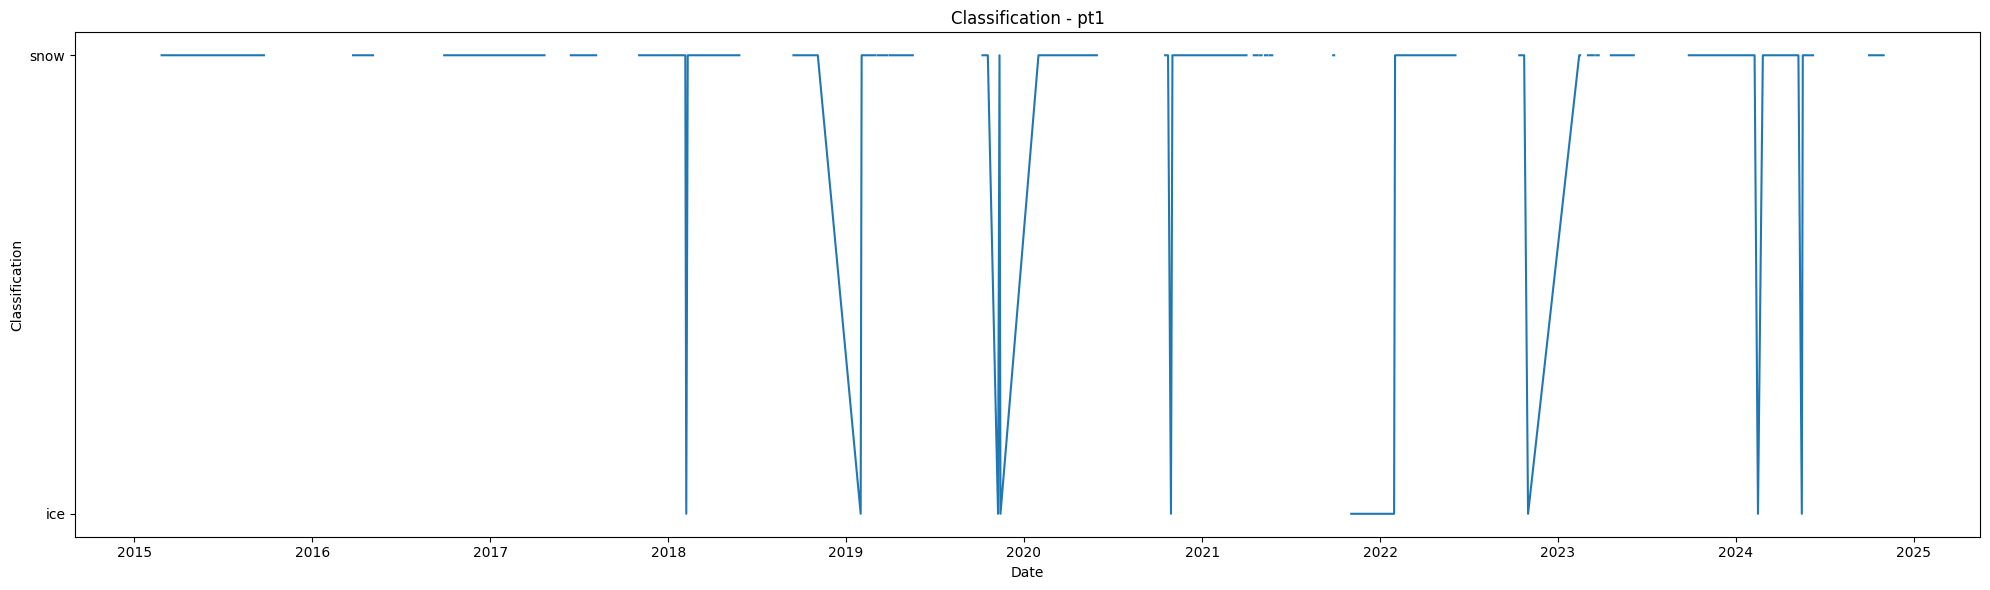

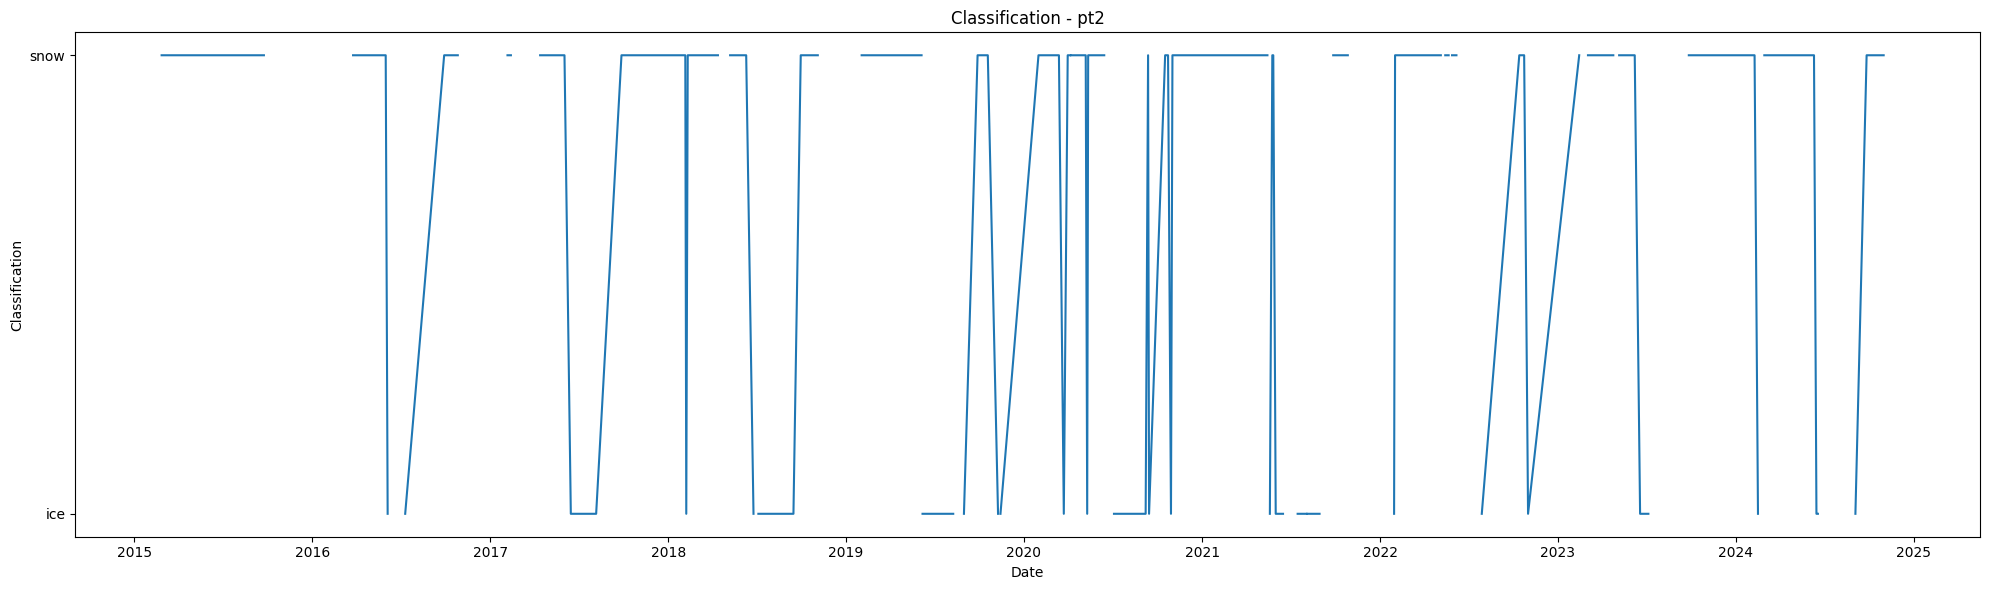

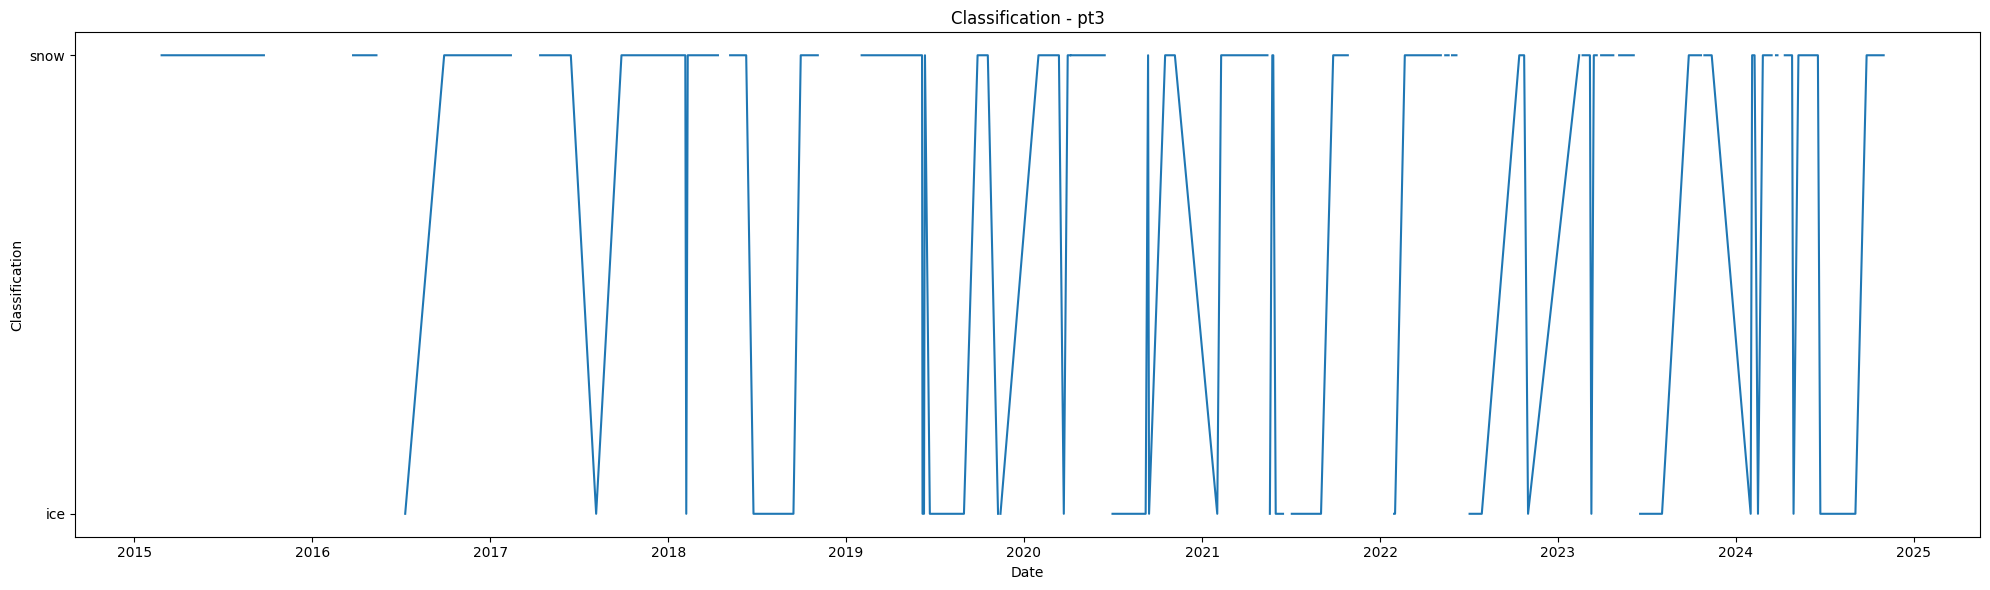

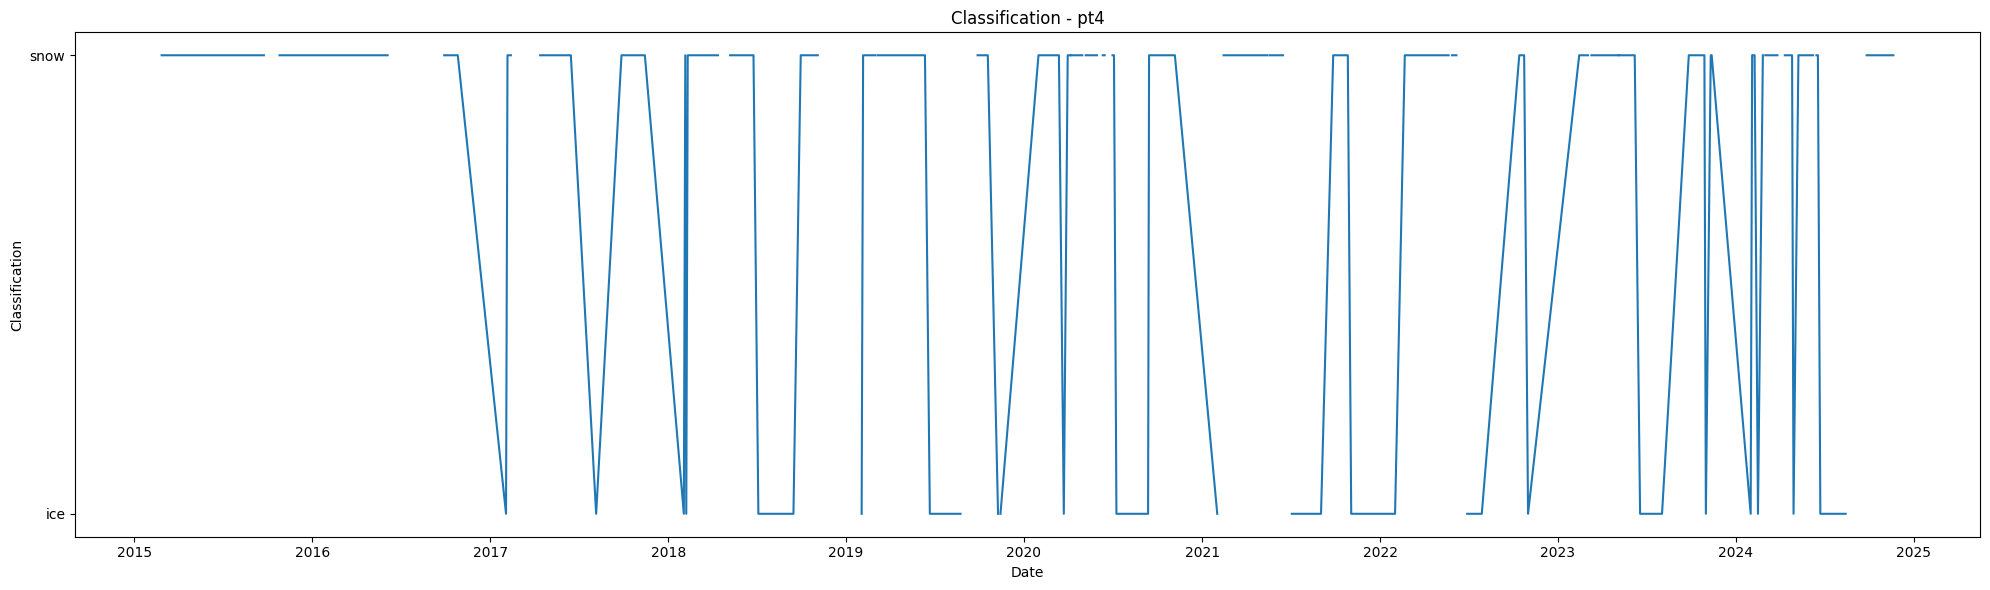

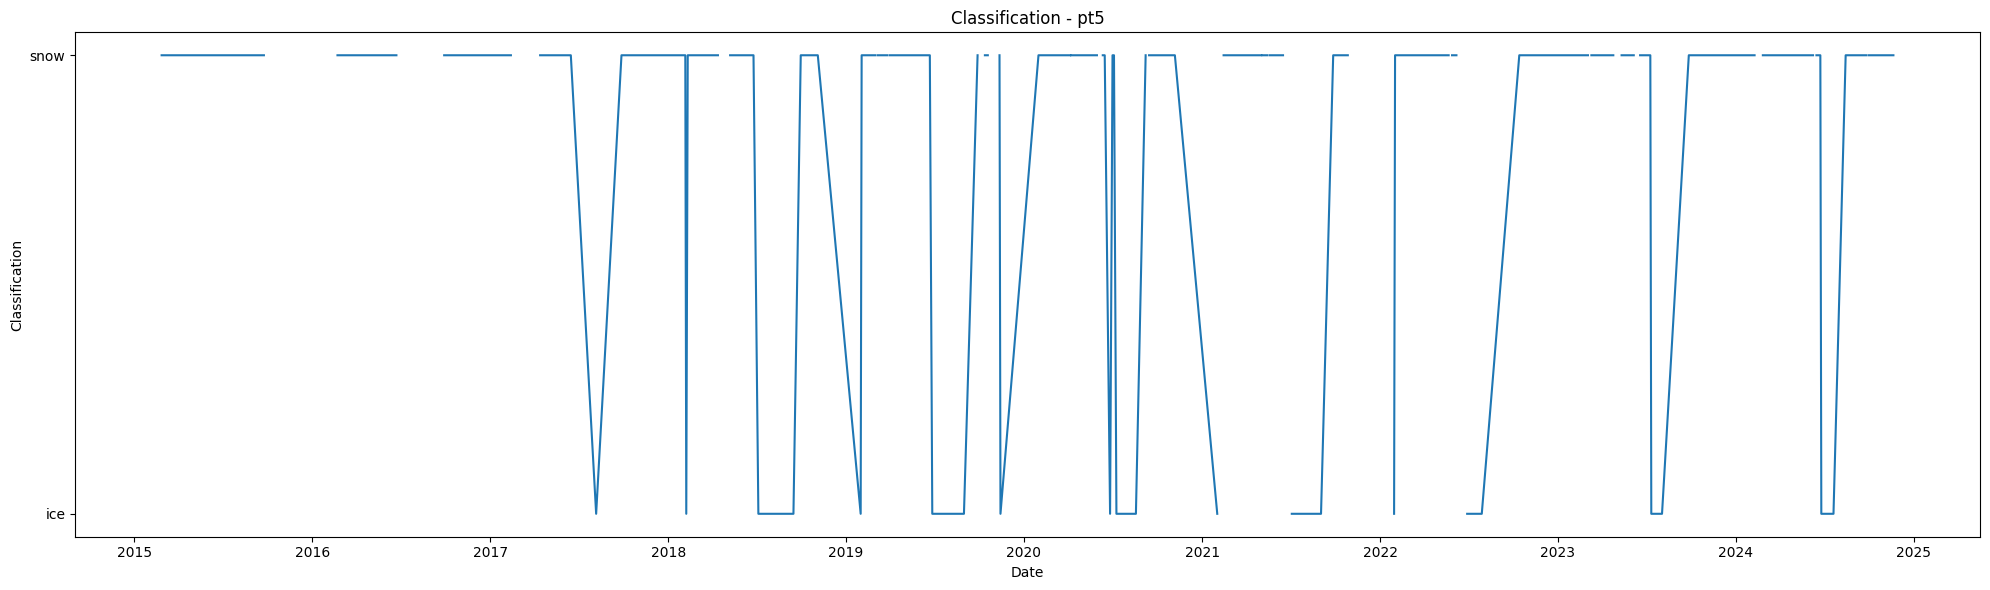

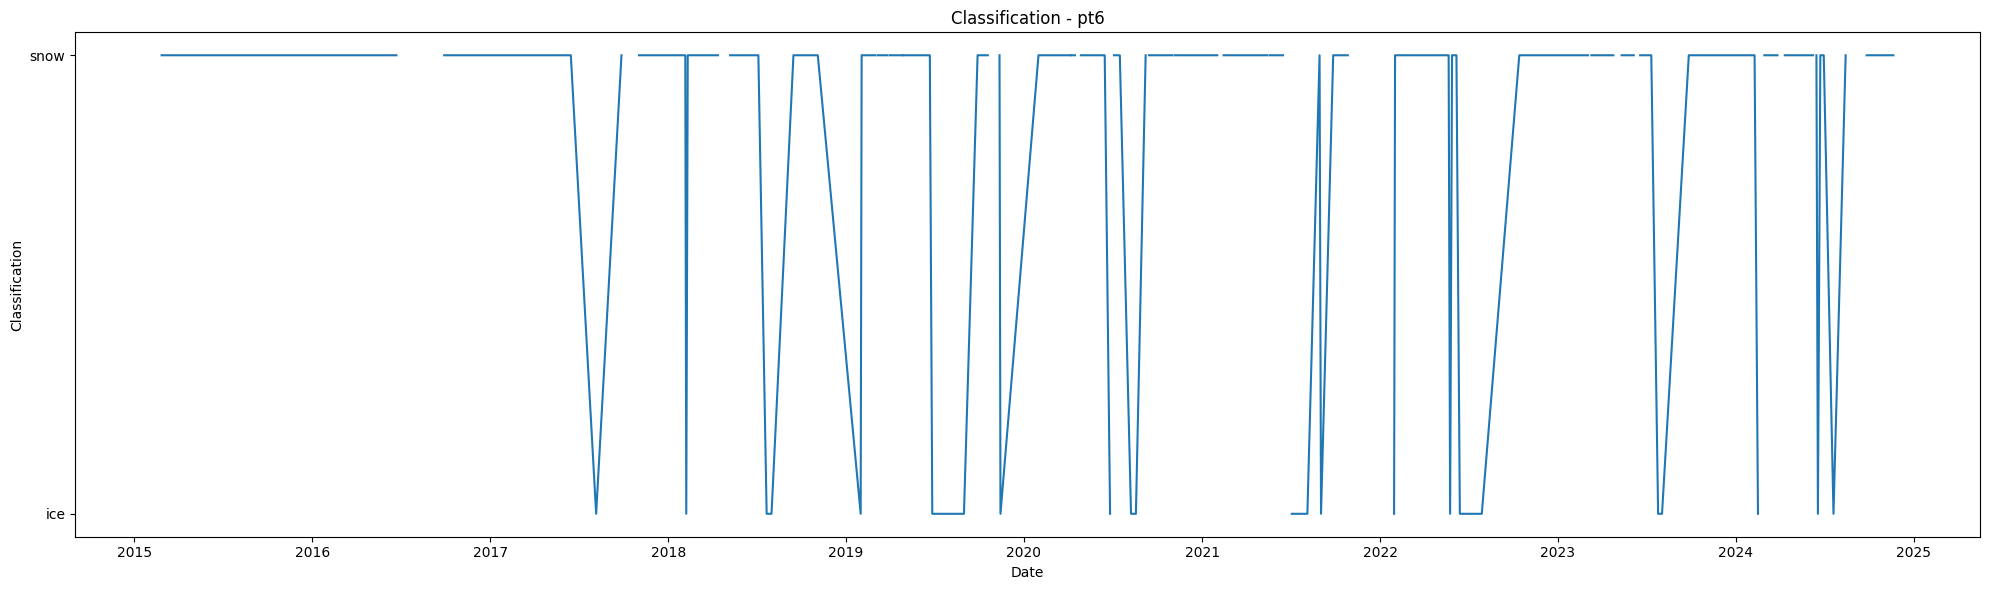

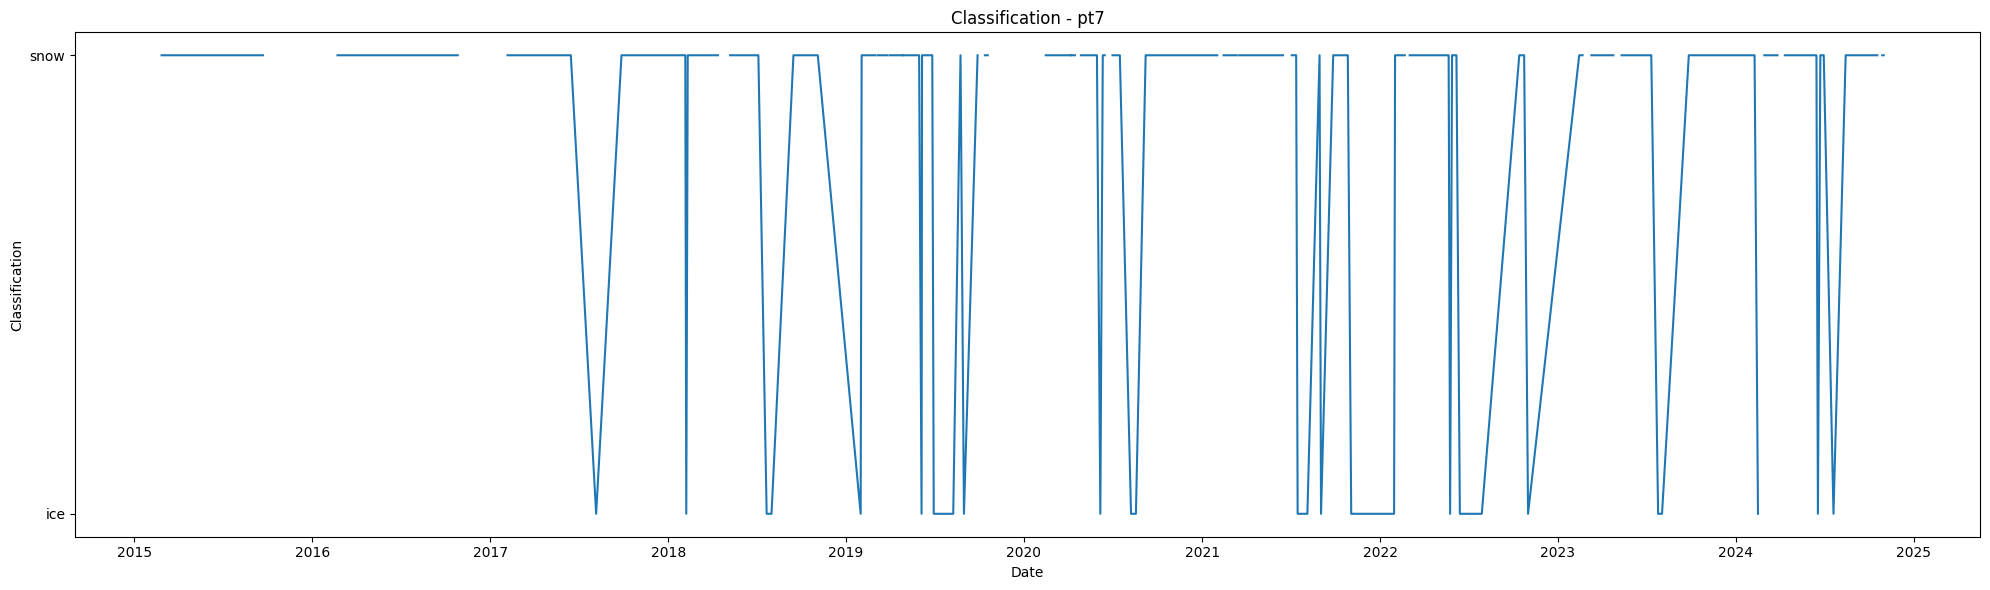

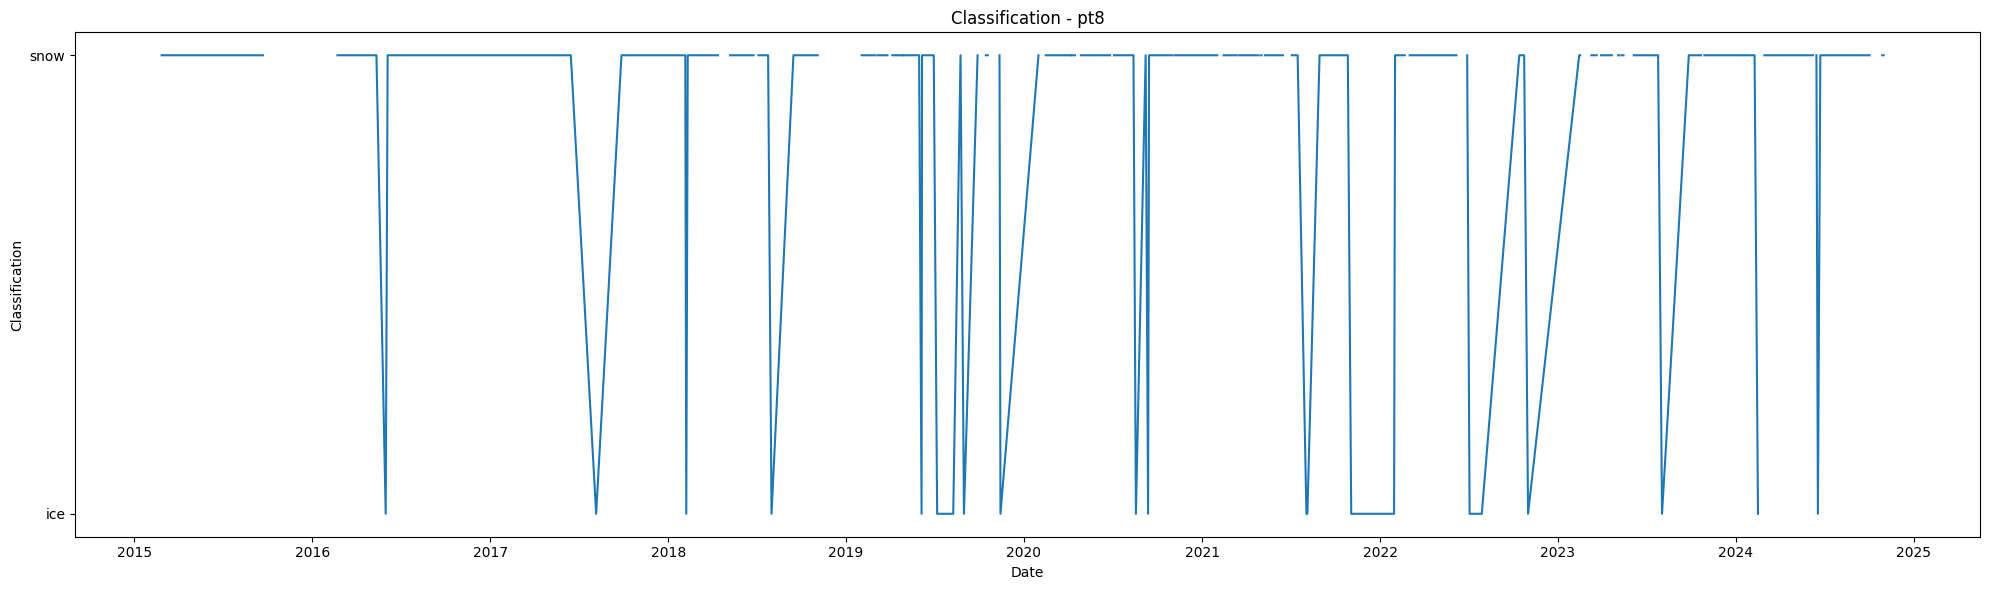

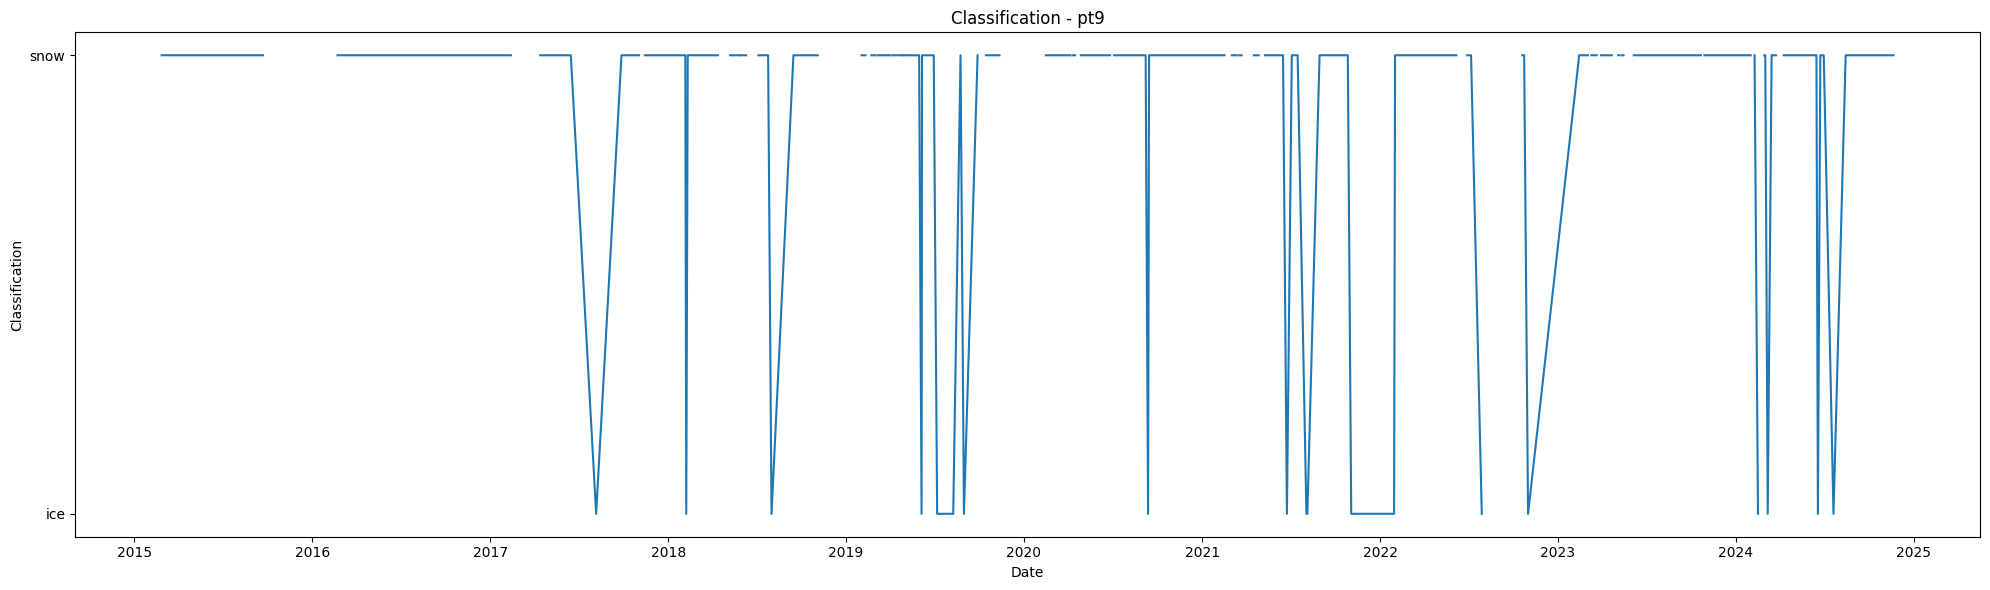

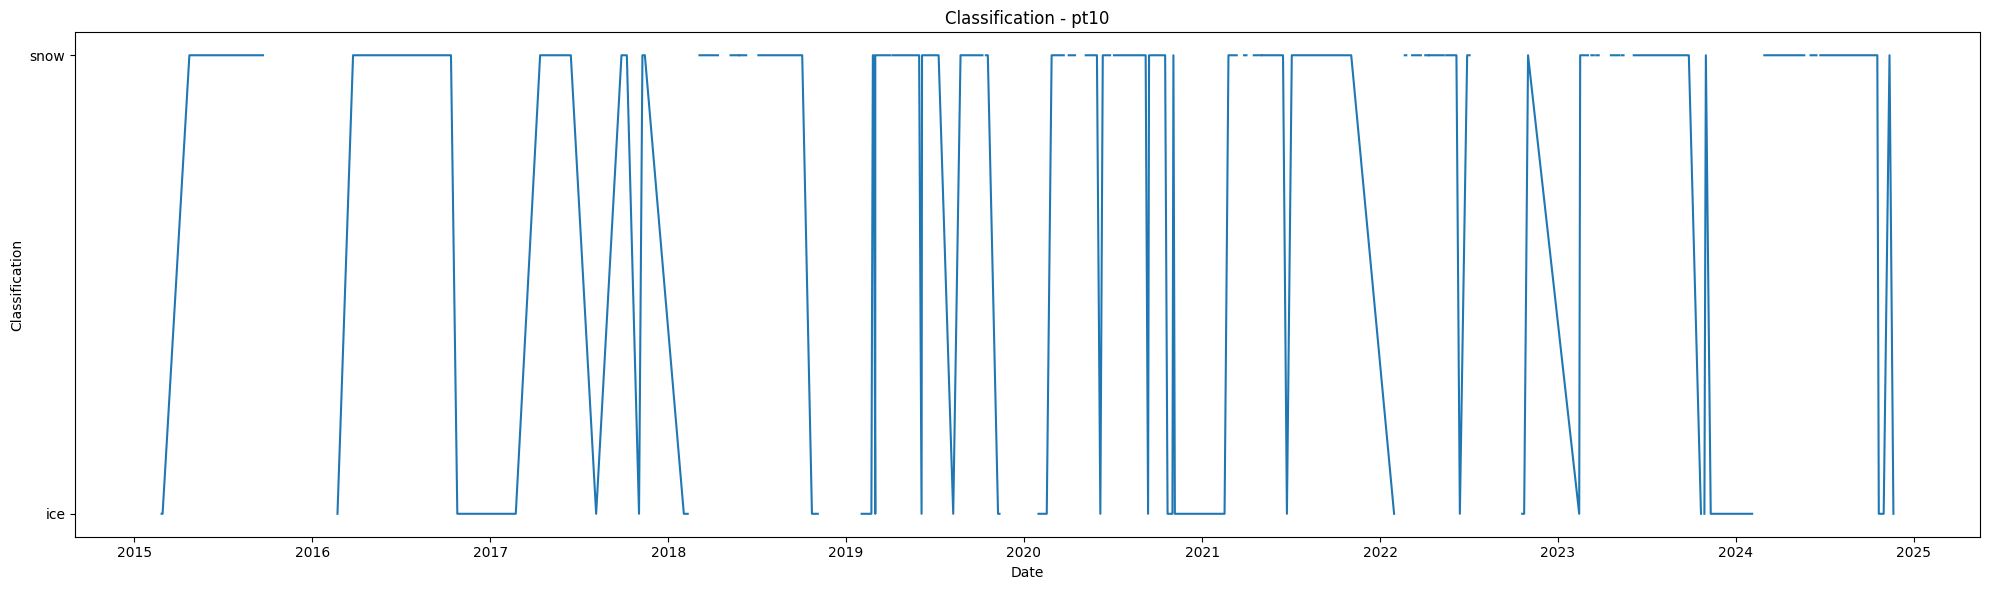

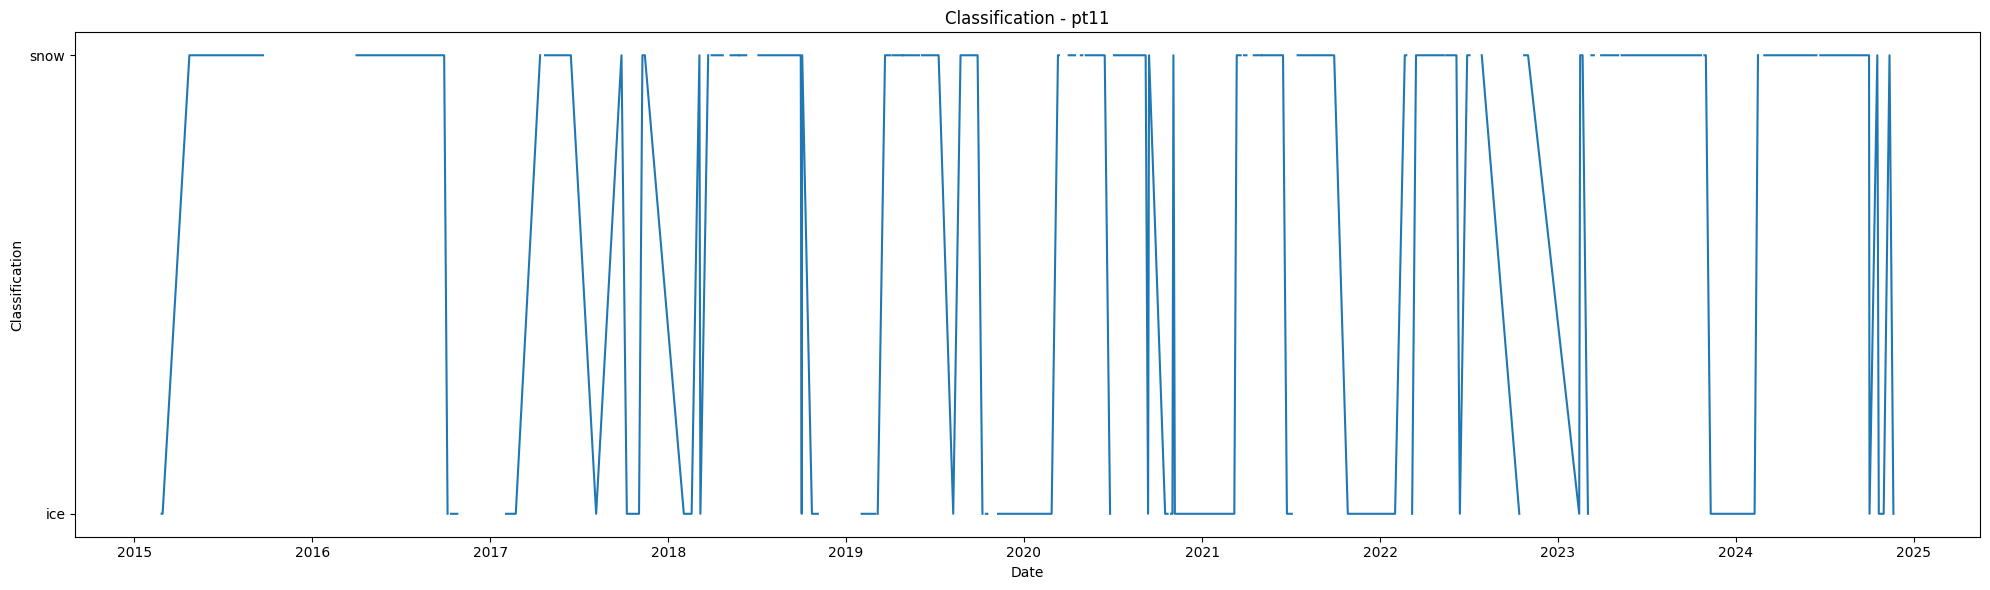

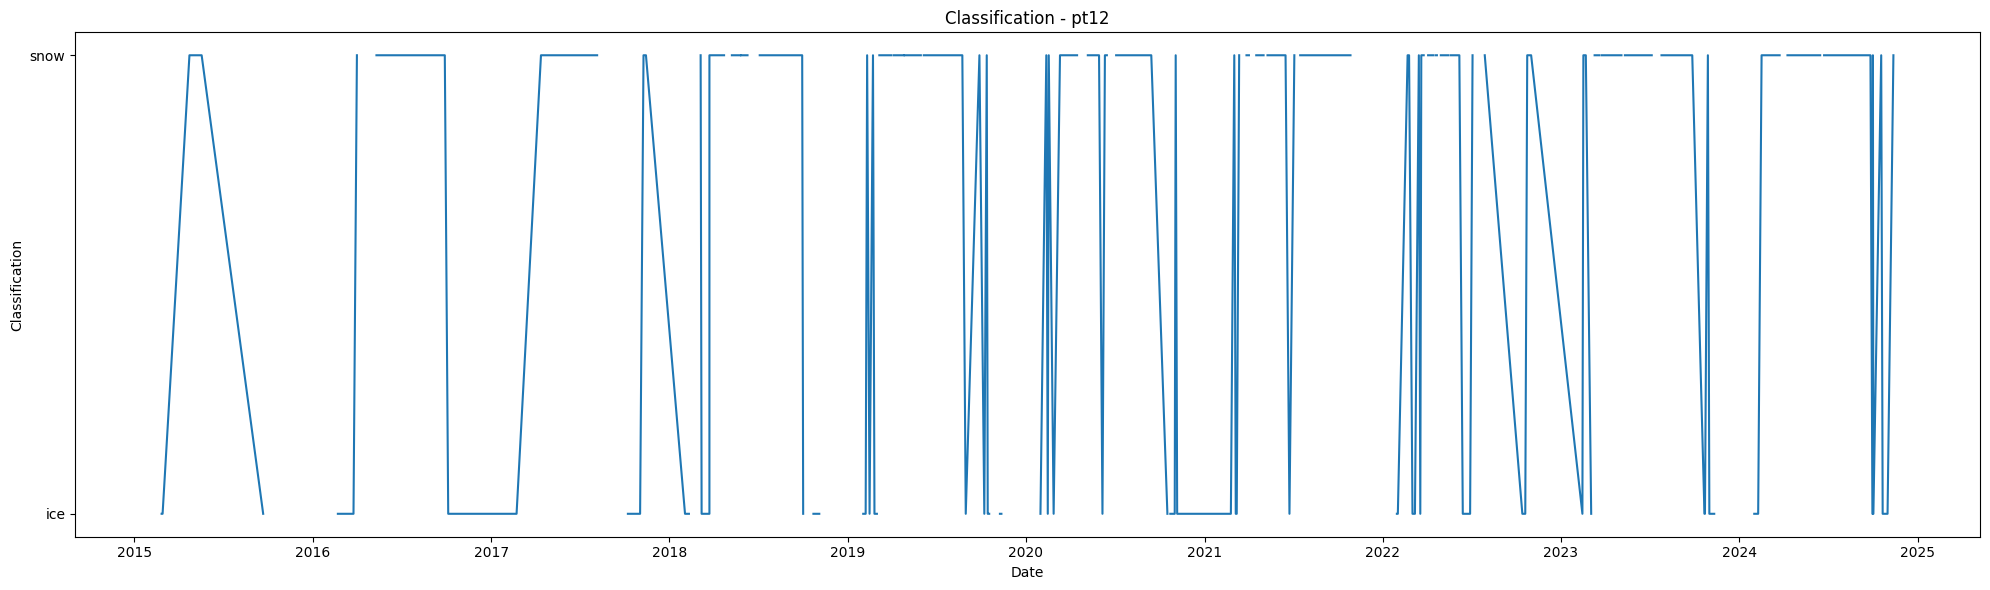

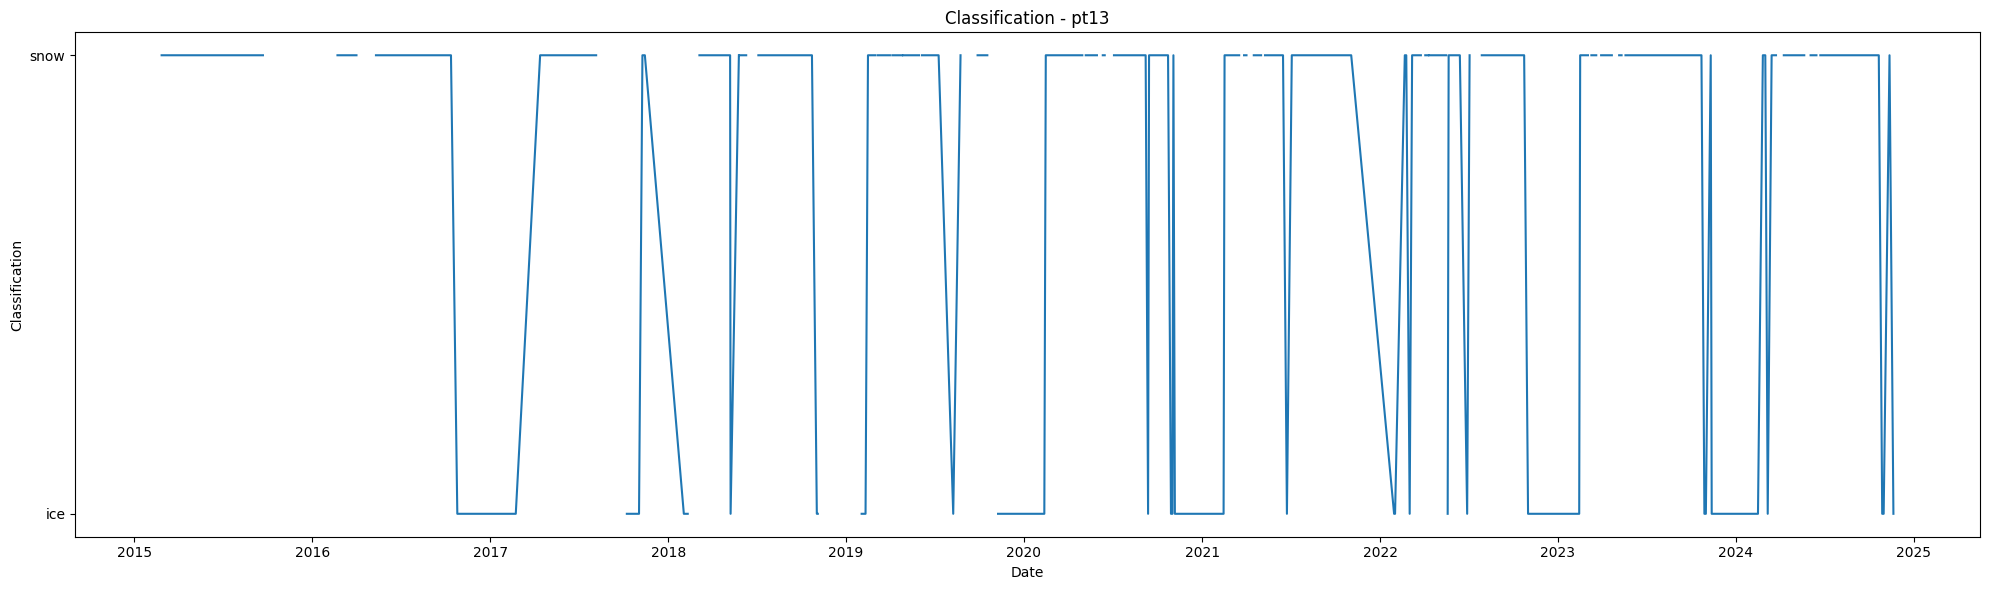

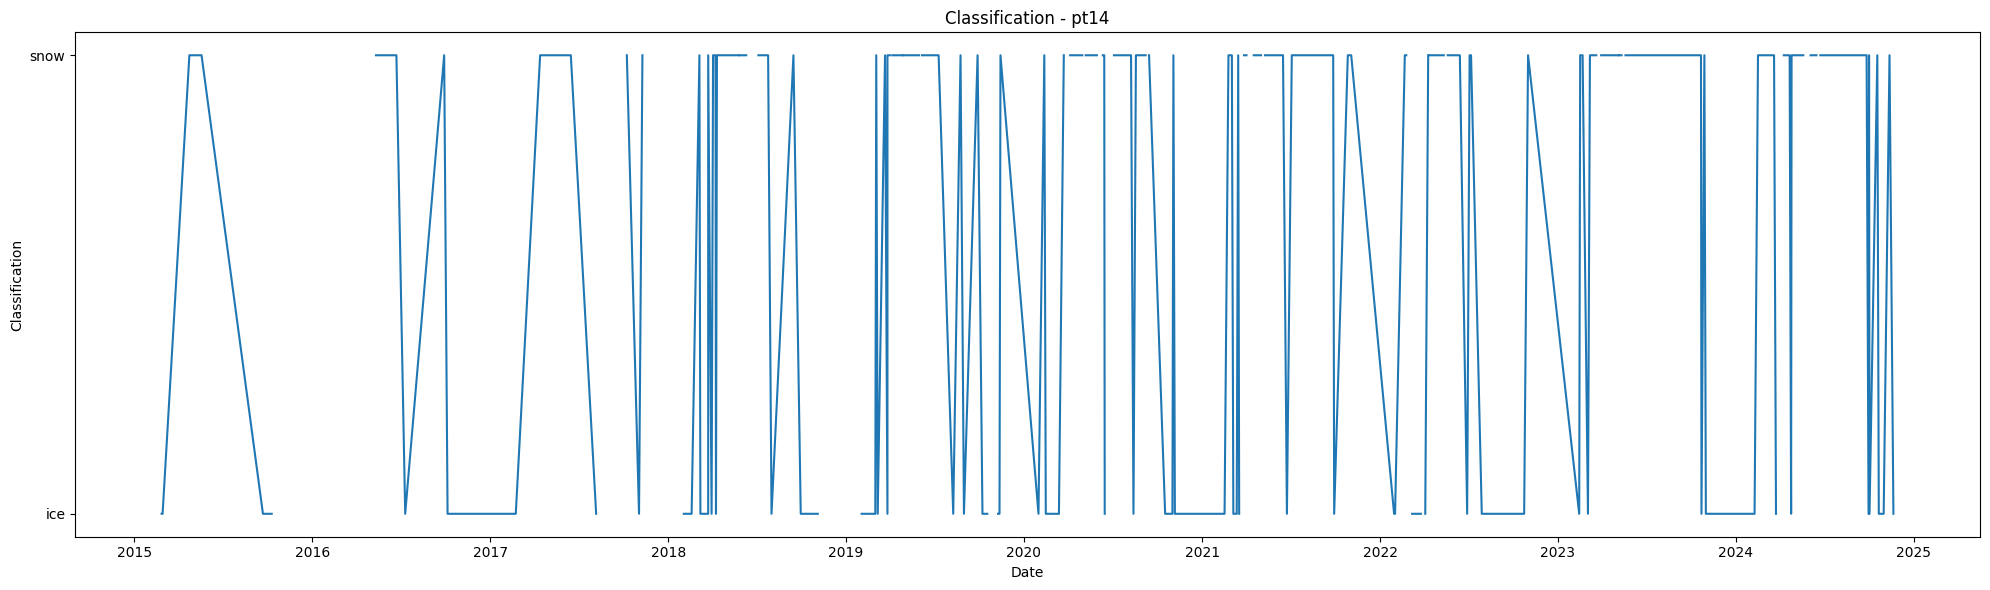

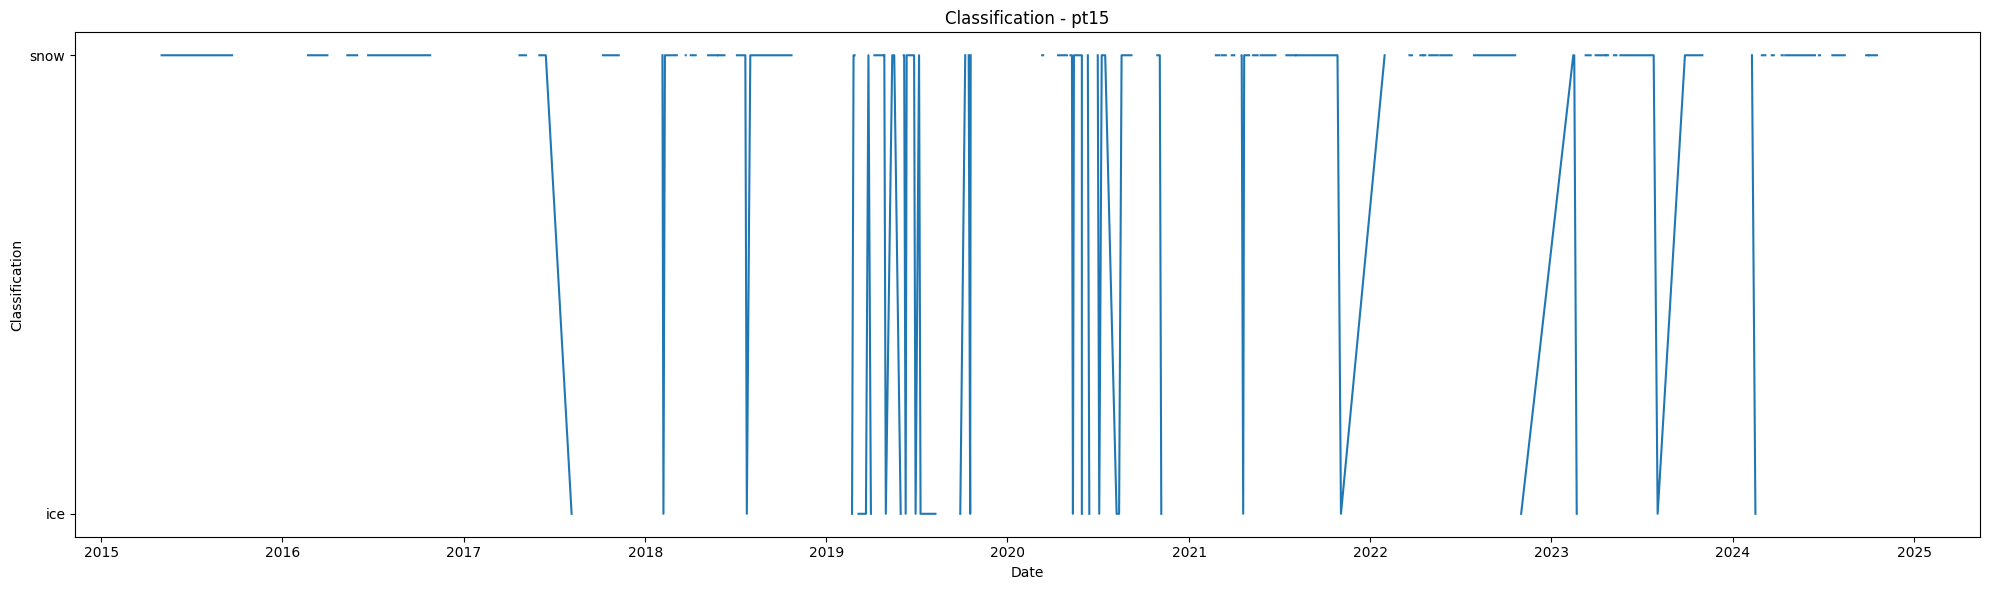

In [16]:
#plot classification
for pt_name, pt_df in classified_points_dict.items():
    plt.figure(figsize=(20, 6))
    plt.title(f'Classification - {pt_name}')
    plt.xlabel('Date')
    plt.ylabel('Classification')
    
    #plot classification over time
    plt.plot(pt_df['time'], pt_df.iloc[:, 1])  # second column after 'time'
    
    # Replace y-axis ticks with labels
    plt.yticks([1,2], ['ice', 'snow'])

    plt.tight_layout()
    plt.show()

# export results

In [17]:
for pt_name, df in classified_points_dict.items():
    output_path = f"{out_path}{pt_name}_classified.csv"
    df.to_csv(output_path, index=False)